In [1]:
############# AT THE START, WE INSTALL PACKAGES WE NEED ###################################

# We use a package that might be new to some of you, called "INLA" 
# This package helps implement Bayesian methods and helps make some of our steps fast/easy to implement
# We will explain it as we go through this code 

############# OPEN R, THEN RUN THE FOLLOWING COMMAND ###################

install.packages("INLA",repos=c(getOption("repos"),INLA="https://inla.r-inla-download.org/R/stable"), dep=TRUE)
install.packages("fmesher", dependencies = TRUE)
install.packages("MatrixModels", type = "source")
install.packages("exactextractr")
install.packages("sn" ,dependencies = TRUE)
packages <- c("terra","dplyr","spdep", "exactextractr", "sf","ggplot2","viridis","sn","fmesher","exactextractr","fields")
package.check <- lapply(packages, FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
        install.packages(x, dependencies = TRUE)
        library(x, character.only = TRUE, quietly=TRUE)
    }
})
Sys.setenv("AWS_DEFAULT_REGION" = 'us-west-2')

##### THE FOLLOWING COMMANDS ARE FOR THE INSTALLATION OF PACKAGES ON NASA MAAP #####
##### CONDA-FORGE YOUR WAY THROUGH PACKAGES THAT DID NOT INSTALL ##########

# conda install conda-forge::r-fmesher
# conda install conda-forge::r-exactextractr
# conda install conda-forge::r-sn
# conda install conda-forge::r-inlabru
# conda install conda-forge::r-fields

In [1]:
############## LOAD PACKAGES ###########

library("fmesher")
library(MatrixModels)
library(Matrix)
library(INLA)
library(inlabru)
library("jpeg")

library(sf)
library(terra)
library(dplyr)
library(spdep)
library(raster)
library(exactextractr)

library(ggplot2)
library(viridis)
library(sn)

Warning message:
“package ‘INLA’ was built under R version 4.3.2”
Loading required package: sp

This is INLA_24.02.09 built 2024-02-09 03:35:28 UTC.
 - See www.r-inla.org/contact-us for how to get help.
 - List available models/likelihoods/etc with inla.list.models()
 - Use inla.doc(<NAME>) to access documentation

Linking to GEOS 3.12.0, GDAL 3.7.2, PROJ 9.3.0; sf_use_s2() is TRUE

terra 1.7.55


Attaching package: ‘dplyr’


The following objects are masked from ‘package:terra’:

    intersect, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`


Attaching package: ‘raster’


The following object is masked from ‘package:dplyr’:

    select


Loading required

This notebook shows how to integrate Mexican NFI-estimated AGBD (3rd cycle), ESA CCI Biomass AGBD (see https://climate.esa.int/en/projects/biomass/) and GEDI Forest Height estimates (see https://glad.umd.edu/dataset/gedi)

We have also created two fake areas where deforestation will occur in the future. At the end of this notebook, we will predict AGBD in these areas before deforestation using all of the above data!!


################################# Model-assisted vs model-based #################################

The approach presented in this notebook is a Geostatistical Model-Based (GMB) approach. 

As noted from McRoberts et at (2022): With model-based inference each population unit is assumed to have an entire distribution of possible values as opposed to design-based inference, for which each population unit is assumed to have one and only one possible value. Standard model-based terminology specifies use of the verb “to predict” when referring to random variables and “to estimate” when referring to fixed value parameters. Model-based inferences do not require probability samples, although they can be used, and in many instances may be preferable.

################################# Geostatistical Model-based Estimation #########################

Our target variable (AGBD) at any given location (s) is assumed to follow the following linear model

\begin{align}
y(s) = \alpha + \beta.x(s) + \epsilon(s)
\end{align}

Where y(s) is the estimated AGBD at location s, and x(s) is a covariate (e.g. CCI Biomass map). Further, $\epsilon(s)$ is the random error. This should be straightforward to solve. However, the errors of $\alpha$ and $\beta$ could be spatially varying across the extent of Japan, and hence may not be "fixed". To deal with this, we add a spatially-varying term to $\alpha$ and $\beta$ that will capture this variance.  

\begin{align}
y(s) = (\alpha + \tilde{\alpha}(s)) + (\beta + \tilde{\beta}(s)).x(s) + \epsilon(s)
\end{align}

Further, if you wanted to add another covariate (e.g. the CCI as well as a map of GEDI height estimates) to predict AGBD, the model will look like

\begin{align}
y(s) = (\alpha + \tilde{\alpha}(s)) + (\beta + \tilde{\beta}(s)).x1(s) + (\eta + \tilde{\eta}(s)).x2(s) + \epsilon(s) 
\end{align}

Most of the values should be familiar. $\alpha$, $\beta$ and $\eta$ are constant regression parameters. x1 and x2 are our covariates (here, the CCI map and the GEDI height map). $\alpha$, $\beta$ and $\eta$ have associated errors $\tilde{\alpha}$, $\tilde{\beta}$ and $\tilde{\eta}$ that are spatially autocorrelated. These errors capture the spatially-varying component of $\alpha$, $\beta$ and $\eta$. If you solve this equation at every location s, you will have accounted for the spatial dependence among residuals. In a Bayesian hierarchical framework, it is possible to estimate the spatial covariance parameters and, hence, propagate their uncertainties through to the prediction of the outcome variable (Babcock et al. 2015). 

Solving the above model is natively is computationally expensive when the number of observations becomes large. We can circumvent this by splitting Japan up into smaller regions. This is done by the use of a mesh, and approximating the model outputs for each node/vertex of the mesh. So, we first define an underlying "mesh", which draws a graph of triangles across the study area. On the vertices of triangles, we define a neighbor-based spatial model where two vertices are neighbors if there is a triangle edge connecting them. To extend this to continuous locations, the value of $\tilde{\alpha}$, $\tilde{\beta}$ and $\tilde{\eta}$ at any location (s) lying within a triangle is linearly interpolated from the 3 vertices of the containing triangle. The reason why this is more computationally effecient is that the process on the vertices is sparse, i.e. for any given vertex, it only needs the information from the connected vertices. This will become clearer as we go through the code. 

In [2]:
######################### LOAD THE OUTLINE OF Japan AND ADMIN BOUNDARIES #############
options(repr.plot.width=10, repr.plot.height=10)

Japan = st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/JAPAN/Japan_country.gpkg", quiet = TRUE) %>% st_union() %>% st_transform(crs = 6933) # Provided by CONAFOR and converted to a projected CRS so we can work in units of meters
Deforestation = st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/JAPAN/Japan_deforestation.gpkg", quiet = TRUE) %>% st_transform(crs = 6933)  # Regions of deforestation.  

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


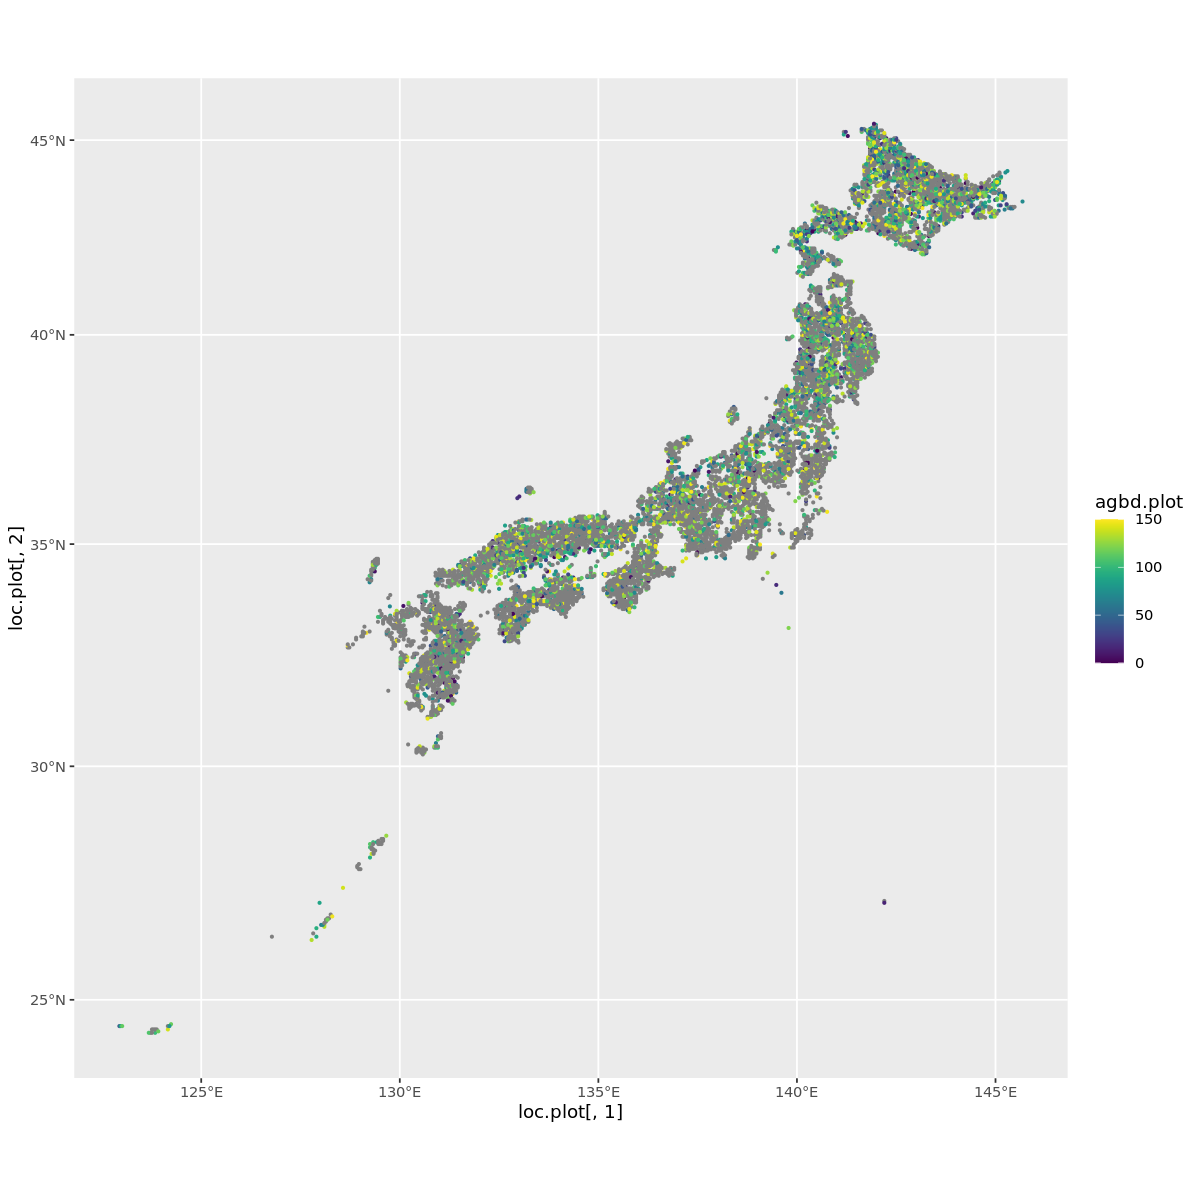

In [3]:
# ########################## READ THE MEXICAN NFI DATA ###################################
plot_WGS84 <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/JAPAN/jp_NFI.gpkg", quiet = TRUE)

# Sample 90% of the data randomly for training and 10% for testing
dt = sort(sample(nrow(plot_WGS84), nrow(plot_WGS84)*.9))
plot_WGS84 <- plot_WGS84[dt,]
plot_WGS84_T <- plot_WGS84[-dt,]

loc.plot.WGS84 <- st_coordinates(plot_WGS84)  ### get the plot locations in WGS84
plot = plot_WGS84 %>% st_transform("epsg:6933") ### convert them to a projected CRS
agbd.plot = plot$AGB ### get the AGBD estimate at each plot location
loc.plot = st_coordinates(plot) ### save the plot location xy coordinates in projected CRS
n.plot = nrow(loc.plot) ### check the number of plots
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot[,1], y = loc.plot[,2], col = agbd.plot),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 150)) + 
           geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

  |======================================================================| 100%


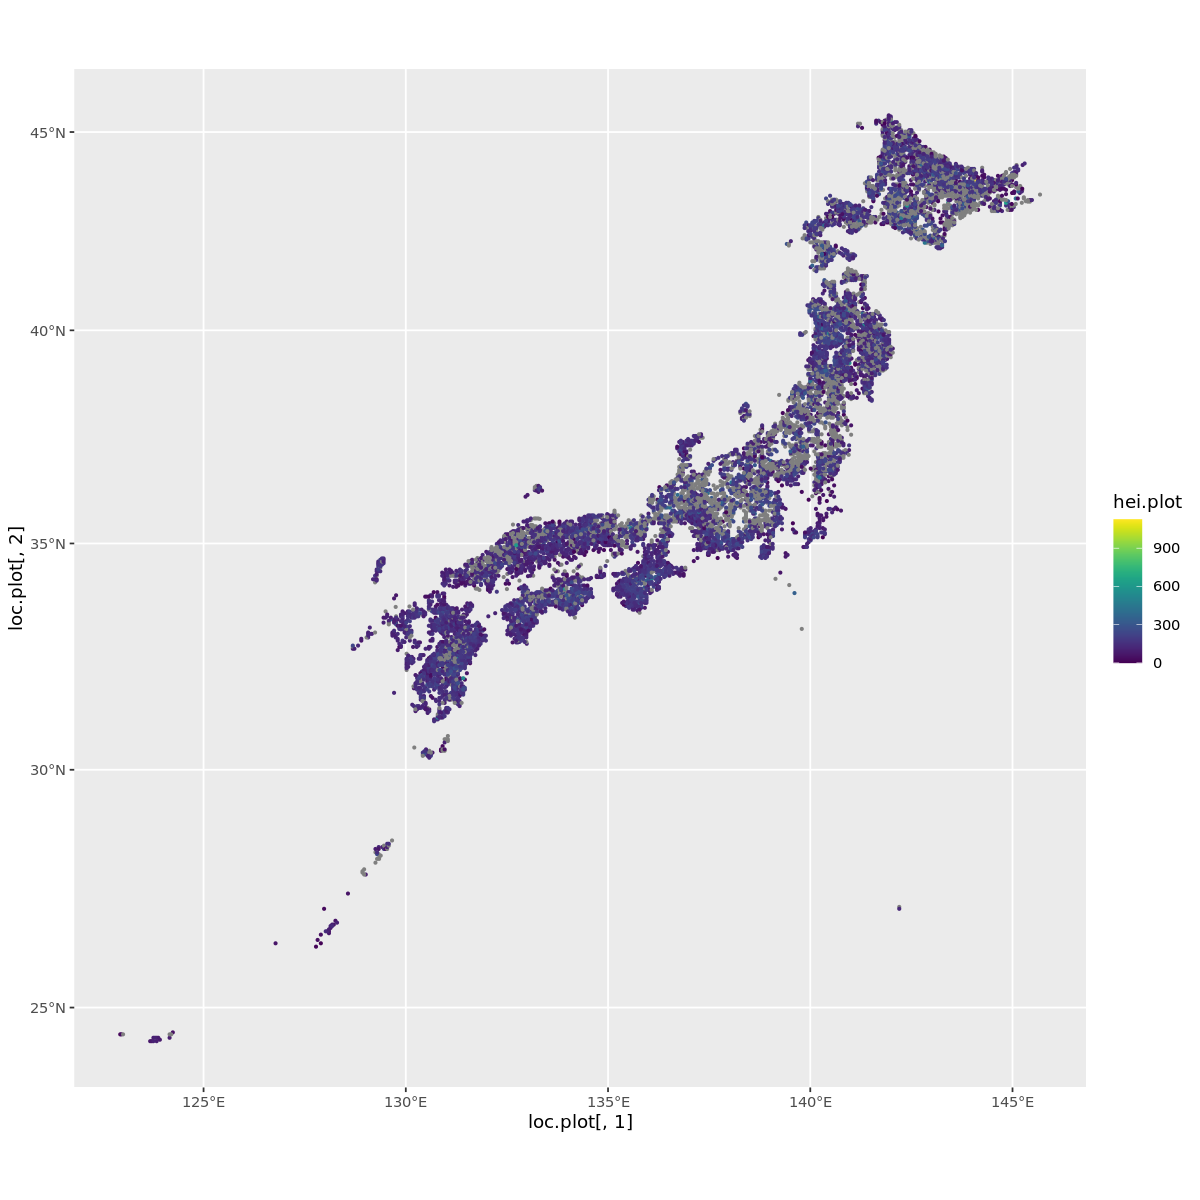

In [4]:
####################### LOAD THE GLAD FOREST HEIGHTS MAP #######################
hei.rast=rast("/projects/my-public-bucket/Data/NASA_CMS_2023/JAPAN/GEDI_L4B_Japan.tif")### Read GLAD FOREST HEIGHT raster, already in projected CRS
# hei.plot = terra::extract(hei.rast, st_buffer(plot,17.84)) ### Extract pixel-level height values at each NFI plot location + 17.84 buffer
# hei.plot = aggregate(x = hei.plot$GLAD_FH_Japan_UINT16_C_6399, by = list(hei.plot$ID), FUN = mean, na.rm=TRUE)[,2] ### Average pixel values per plot
# ggplot() + coord_sf(crs = 6933) + geom_point(aes(x = loc.plot[,1], y = loc.plot[,2], col = hei.plot),size=0.5) + scale_color_viridis() # make a map to see plot locations and the CCI AGBD values at each location

# In case the weighted-average of pixels under the plot of radius 56.4 m is required, please use the lines below
hei.plot = exactextractr::exact_extract(hei.rast, st_buffer(plot,17.84), 'mean')
ggplot() + coord_sf(crs = 6933) + geom_point(aes(x = loc.plot[,1], y = loc.plot[,2], col = hei.plot),size=0.5) + scale_color_viridis() # make a map to see plot locations and the CCI AGBD values at each location

Cannot preload entire working area of 617789238 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


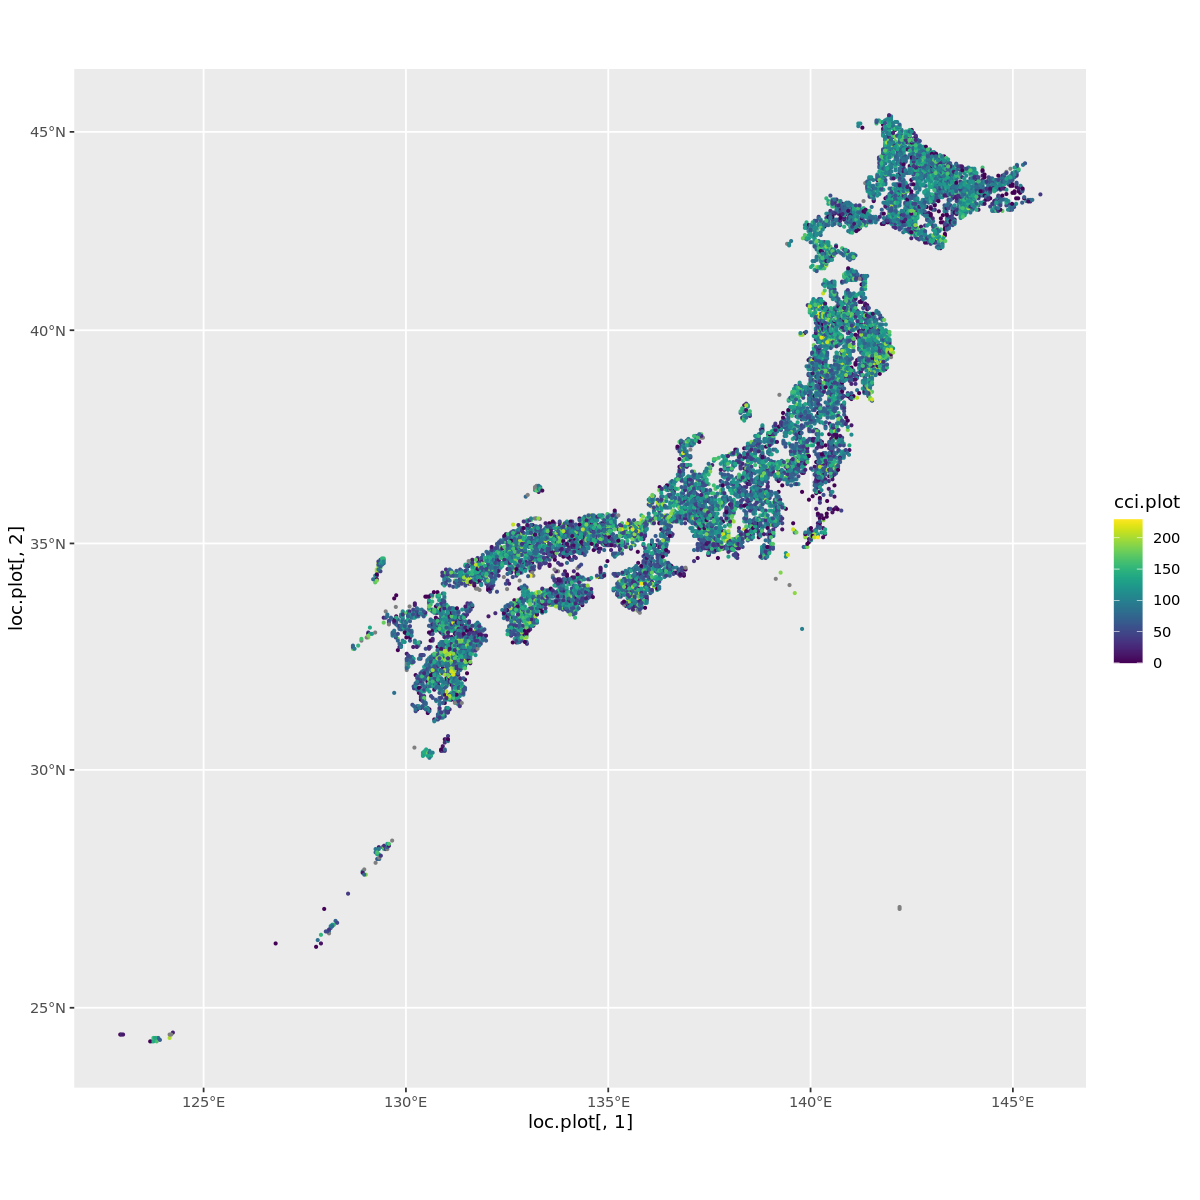

In [5]:
####################### LOAD THE CCI BIOMASS MAP #######################
cci.rast=rast("/projects/my-public-bucket/Data/NASA_CMS_2023/JAPAN/CCI_Japan_6933.tif") ### Read CCI raster, already in projected CRS
# cci.plot = terra::extract(cci.rast, st_buffer(plot,17.84)) ### Extract CCI pixel-level AGBD values at each NFI plot location + 17.84 buffer
# cci.plot = aggregate(x = cci.plot$cci_Japan, by = list(cci.plot$ID), FUN = mean, na.rm=TRUE)[,2] ### Average pixel values per plot
# ggplot() + coord_sf(crs = 6933) + geom_point(aes(x = loc.plot[,1], y = loc.plot[,2], col = cci.plot),size=0.5) + scale_color_viridis() # make a map to see plot locations and the CCI AGBD values at each location

# In case the weighted-average of pixels under the plot of radius 56.4 m is required, please use the lines below 
cci.plot = exactextractr::exact_extract(cci.rast, st_buffer(plot,17.84), 'mean')
ggplot() + coord_sf(crs = 6933) + geom_point(aes(x = loc.plot[,1], y = loc.plot[,2], col = cci.plot),size=0.5) + scale_color_viridis() # make a map to see plot locations and the CCI AGBD values at each location

DATA <- cbind(loc.plot[,1],loc.plot[,2],cci.plot,hei.plot,agbd.plot) # Create a dataframe with all the data
write.csv(DATA,"/projects/my-public-bucket/Data/NASA_CMS_2023/JAPAN/NFI_CCI_GEDIheights.csv",row.names=FALSE) #Save the data

Warning message:
“Removed 60 rows containing non-finite values (`stat_bin2d()`).”
Warning message:
“Removed 3163 rows containing non-finite values (`stat_bin2d()`).”
Warning message:
“Removed 37 rows containing missing values (`geom_tile()`).”


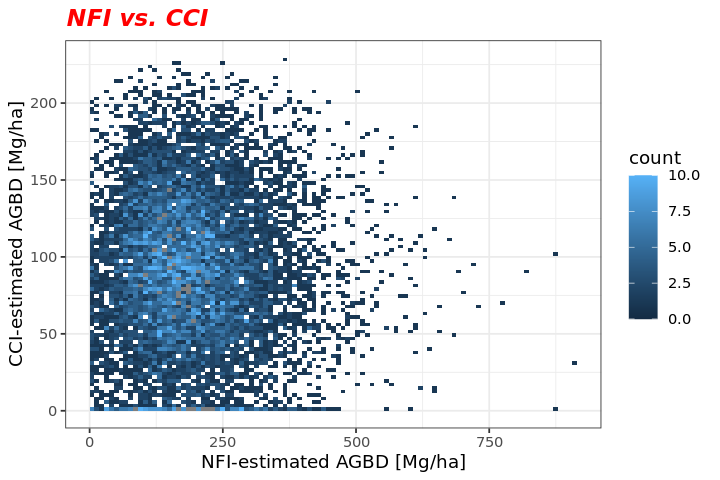

Warning message:
“Removed 60 rows containing non-finite values (`stat_bin2d()`).”


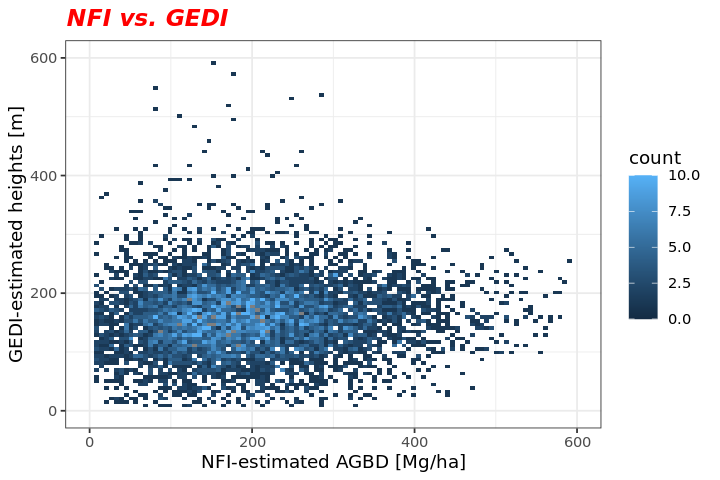

Warning message:
“Removed 3129 rows containing non-finite values (`stat_bin2d()`).”


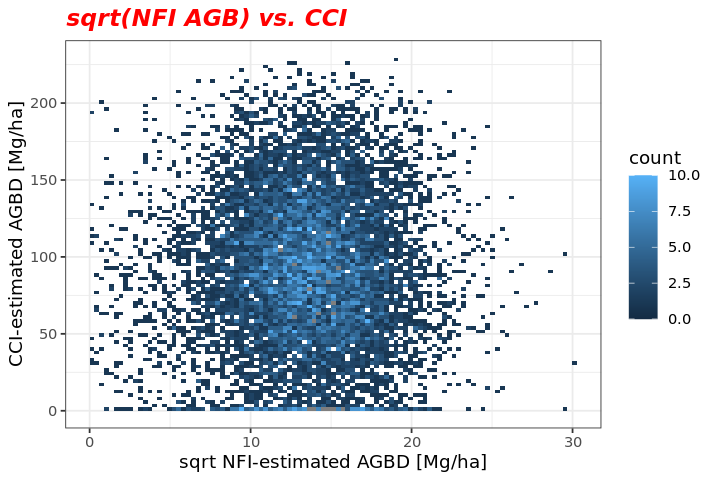

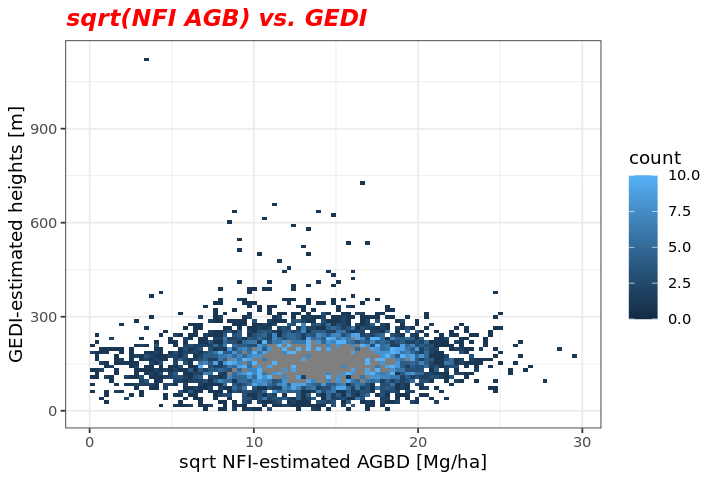

In [10]:
############# RELATION BETWEEN CCI, HEIGHTS AND NFI AT THE PLOT LEVEL ########################

## Now we have NFI plot locations, NFI AGBD estimates, and the cooresponding CCI pixel value and forest height estimate at each location
## Let's see what the relations between them look like 

DATA <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/JAPAN/NFI_CCI_GEDIheights.csv") #Read the saved data
cci.plot <- DATA$cci.plot
hei.plot <- DATA$hei.plot
loc.plot <- data.frame(matrix(ncol = 2, nrow = length(hei.plot))) # Just create empty list to populated with saved NFI xy locations
loc.plot[,1] <- DATA$X
loc.plot[,2] <- DATA$X.1
agbd.plot <- (DATA$agbd.plot) 

options(repr.plot.width=6, repr.plot.height=4)

ggplot(data=DATA, aes(x=agbd.plot, y=cci.plot) ) +
  geom_bin2d(bins = 100) +
  scale_fill_gradient(limits = c(0, 10)) + xlab("NFI-estimated AGBD [Mg/ha]") + ylab("CCI-estimated AGBD [Mg/ha]") + ggtitle("NFI vs. CCI") +
  theme_bw() + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))

ggplot(data=DATA, aes(x=agbd.plot, y=hei.plot) ) +
  geom_bin2d(bins = 100) +
  scale_fill_gradient(limits = c(0, 10)) + xlab("NFI-estimated AGBD [Mg/ha]") + ylab("GEDI-estimated heights [m]") + ggtitle("NFI vs. GEDI") +
  theme_bw() + theme(plot.title = element_text(color="red", size=14, face="bold.italic")) + xlim(0,600) + ylim(0,600)

# The plots show rather poor relations, so let's transform NFI AGBD and try again 

# ############## TRANSFORMATION FOR POOR RESIDUALS ############## 
# Next, we check if square-rooting the NFI-estimated AGBD appears to indicate a better relationship 

DATA$agbd.plot = sqrt(DATA$agbd.plot)

ggplot(data=DATA, aes(x=agbd.plot, y=cci.plot) ) +
  geom_bin2d(bins = 100) +
  scale_fill_gradient(limits = c(0, 10)) + xlab("sqrt NFI-estimated AGBD [Mg/ha]") + ylab("CCI-estimated AGBD [Mg/ha]") + ggtitle("sqrt(NFI AGB) vs. CCI") +
  theme_bw() + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))

ggplot(data=DATA, aes(x=agbd.plot, y=hei.plot) ) +
  geom_bin2d(bins = 100) +
  scale_fill_gradient(limits = c(0, 10)) + xlab("sqrt NFI-estimated AGBD [Mg/ha]") + ylab("GEDI-estimated heights [m]") + ggtitle("sqrt(NFI AGB) vs. GEDI") +
  theme_bw() + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))

## These are perhaps better? We could experiment more, but let's see how we do with sq-root transformation only

In [9]:
############### INTRODUCTING BAYESIAN MODELLING IN R #####################################

### In this cell, we want to get familiar with the Package INLA. To do so, we do a simple demonstration, comparing INLA outputs to 
### fitting a linear regression in R. INLA is a package that makes Bayesian inference easier, it can fit Bayesian models very fast!
### For those familiar with Bayesian statistics, a gentle introduction to INLA is available: https://www.precision-analytics.ca/articles/a-gentle-inla-tutorial/
### In this cell, we fit a linear model the usual way, and then the INLA way, and compare results. 

### All should be well familiar with fitting linear regressions in R. If we took our NFI AGBD, CCI AGBD, and Heights estimates, we would fit a model like this:

DATA <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/JAPAN/NFI_CCI_GEDIheights.csv")
agbd.plot <- sqrt(DATA$agbd.plot)
DATA$agbd.plot <- sqrt(DATA$agbd.plot)

LM_model <- (lm((agbd.plot)~(cci.plot)+(hei.plot), na.action=na.omit))
summary(LM_model)
print("--------GREAT, I'VE SOLVED A LINEAR REGRESSION MODEL ABOVE -----------")

### However, in our case, we want to capture the model parameters (alpha, beta and eta) and view their distribution, i.e. we want the Bayesian model output
### In other words, we want to see what are their posterior distributions (min, max, 25th, 50th and 75th percentile) when modelled as Guassian Processes
### See the example below, which uses the INLA package to do so 

formula = (agbd.plot)~(cci.plot)+(hei.plot)
INLA_model <- inla(formula, data=DATA, family="gaussian",control.compute=list(config = T, dic = T, waic = T, cpo=TRUE)) #option cpo is a leave-one-out cross validation
summary(INLA_model)
print("--------GREAT, I'VE SOLVED THE REGRESSION MODEL ABOVE USING PACKAGE INLA ---")

#### Let's do a quick comparison, just to see how our outputs compare 
output <- cbind(summary(LM_model)$coef[,1:2],INLA_model$summary.fixed[,1:5]) # Looking great! 
colnames(output) <- c("lm():Mean","lm():SE","inla():Mean","inla():SD","inla():0.025quant","inla():0.5quant","inla():0.975quant")
output # Looking great! 

#### The first 2 columns give you the same estimates if you had done just a linear regression in R as usual
#### The last 6 columns give you the INLA estimates of the model parameters
### Notice the similarities! LM gives you mean and SE, and INLA gives you the mean, SD and all quantiles
### Here is also a nice tutorial that can help understand the differences between INLA and a usualy linear regression in R: https://julianfaraway.github.io/brinla/examples/chicago.html
### And one more tutorial if that wasn't enough: https://www.paulamoraga.com/book-geospatial/sec-inla.html


Call:
lm(formula = (agbd.plot) ~ (hei.plot), na.action = na.omit)

Residuals:
    Min      1Q  Median      3Q     Max 
-272.67  -77.14  -12.13   63.66  674.88 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 187.14133    3.43551  54.473  < 2e-16 ***
hei.plot      0.08686    0.02002   4.338 1.46e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 107.2 on 7237 degrees of freedom
  (3129 observations deleted due to missingness)
Multiple R-squared:  0.002593,	Adjusted R-squared:  0.002456 
F-statistic: 18.82 on 1 and 7237 DF,  p-value: 1.458e-05


[1] "--------GREAT, I'VE SOLVED A LINEAR REGRESSION MODEL ABOVE -----------"



Call:
   c("inla.core(formula = formula, family = family, contrasts = contrasts, 
   ", " data = data, quantiles = quantiles, E = E, offset = offset, ", " 
   scale = scale, weights = weights, Ntrials = Ntrials, strata = strata, 
   ", " lp.scale = lp.scale, link.covariates = link.covariates, verbose = 
   verbose, ", " lincomb = lincomb, selection = selection, control.compute 
   = control.compute, ", " control.predictor = control.predictor, 
   control.family = control.family, ", " control.inla = control.inla, 
   control.fixed = control.fixed, ", " control.mode = control.mode, 
   control.expert = control.expert, ", " control.hazard = control.hazard, 
   control.lincomb = control.lincomb, ", " control.update = 
   control.update, control.lp.scale = control.lp.scale, ", " 
   control.pardiso = control.pardiso, only.hyperparam = only.hyperparam, 
   ", " inla.call = inla.call, inla.arg = inla.arg, num.threads = 
   num.threads, ", " keep = keep, working.directory = working.directory,

[1] "--------GREAT, I'VE SOLVED THE REGRESSION MODEL ABOVE USING PACKAGE INLA ---"


ERROR: Error in data.frame(..., check.names = FALSE): arguments imply differing number of rows: 2, 3


################### SOLVING THE GEOSPATIAL MODEL WE DEFINED FOR Japan ###########

Since we are now familiar with INLA, let's try to solve our model: 

\begin{align}
y(s) = (\alpha + \tilde{\alpha}(s)) + (\beta + \tilde{\beta}(s)).x1(s) + (\eta + \tilde{\eta}(s)).x2(s) + \epsilon(s)
\end{align}

Solving this model is computationally expensive. Instead, an approximation of the solutions can be constructed, typically based upon discretizations of space, i.e. breaking Japan up by a mesh. The solutions then, in turn, are an approximation of the true solution. This method of discretization is called a finite element method (FEM), very commonly used in physics and engineering.

The steps followed below are first explained in words: 

(1) We start with building a mesh over Japan. These are our finite elements. 

(2) We then define a spatial model for each spatially-varying parameter ($\tilde{\alpha}(s)$, $\tilde{\beta}(s)$ and $\tilde{\eta}(s)$), and we ask INLA to solve it!

Once INLA has done its job, we can check our model residuals and make predictions at our hold-out 10% of NFI plot locations. 

Also, we can get values of $(\alpha + \tilde{\alpha}(s))$, $(\beta + \tilde{\beta}(s))$ and $(\eta + \tilde{\eta}(s))$ for any location we want! 

Since we will have the model's fixed parameters and their spatially-varying components, we can get predicted AGBD at any location we want. 
This means, we can find a patch of newly deforested land, and predict what baseline AGBD would have been there (for example). 
We can also predict AGBD and compare it to CONAFOR's 1 km gridded map. 

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Warning message:
“Removed 23805 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1141 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 920 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 10368 rows containing missing values (`geom_point()`).”


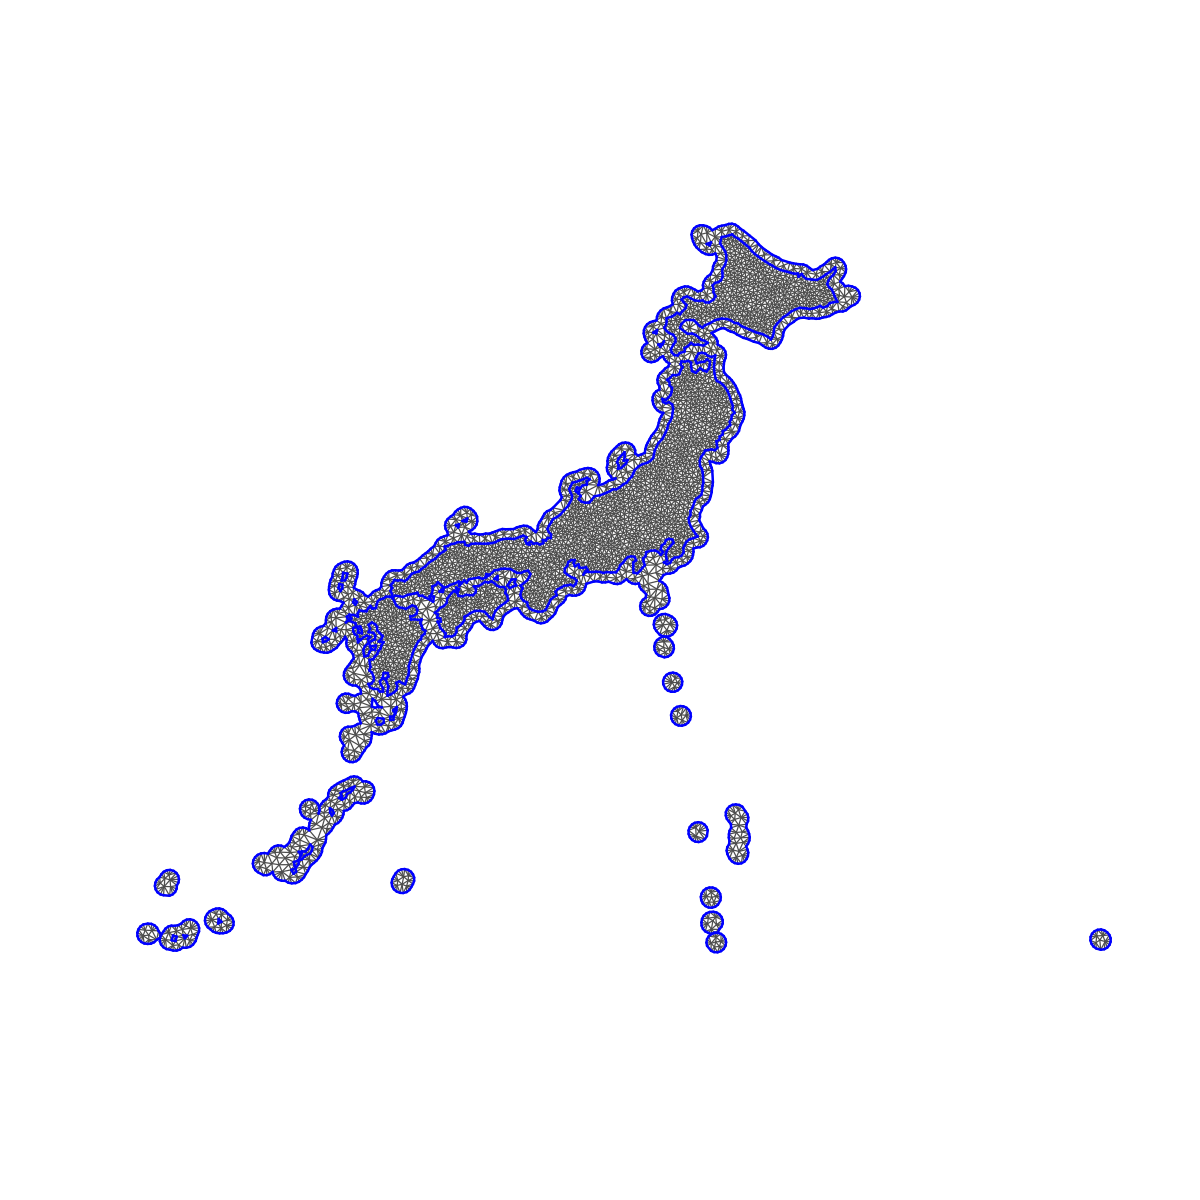

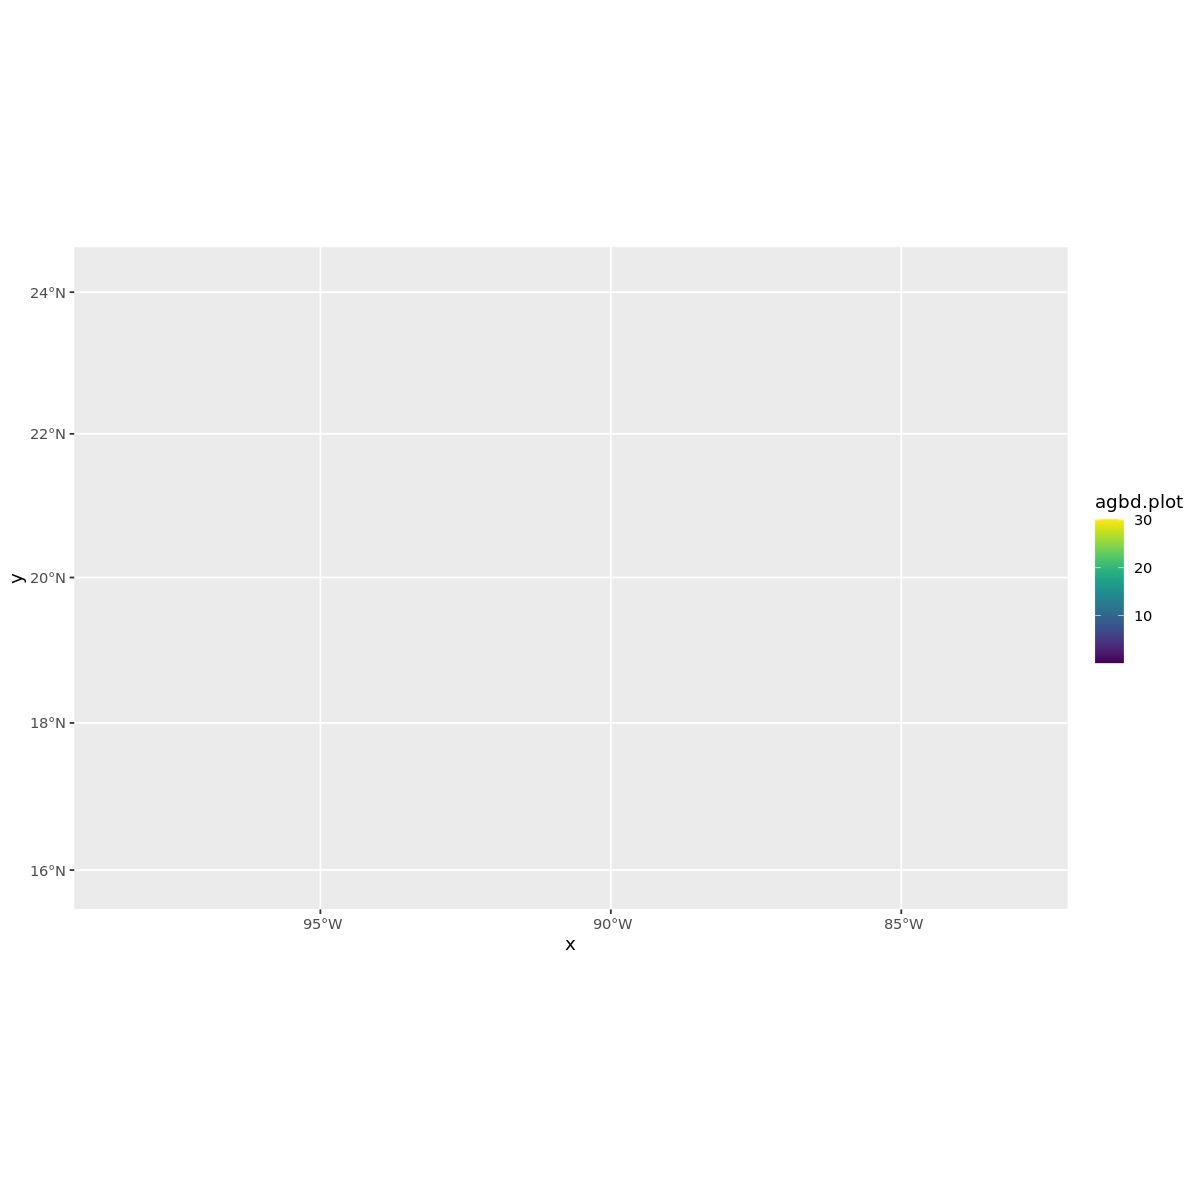

In [19]:
################### MAKING A MESH SURFACE OVER Japan ###################
options(repr.plot.width=10, repr.plot.height=10)

max.edge = 15*10^3 ### Let's start with a 15 km maximimum edge size of our mesh. Note, the units of max.edge must be in meters, so we multiply by 1000. 
Japan.buffer = st_buffer(Japan, dist = max.edge*2) # We also make a 5 km buffer around Japan to prevent boundary effects.
mesh = inla.mesh.2d(boundary = list(as(Japan, "Spatial"), as(Japan.buffer, "Spatial")), max.edge = c(max.edge, 3*max.edge), cutoff = 2*max.edge/3, offset = c(max.edge, 5*max.edge)) 

plot(mesh) ## This is what our mesh looks like         

# Let's zoom in to a corner, so you can see what the mesh and buffer looks like, and also plot two hypothetical regions where we will eventually predict AGBD
ggplot() + inlabru::gg(data = mesh) + coord_sf(crs = 6933) +
         geom_point(aes(x = loc.plot[,1], y = loc.plot[,2], col = agbd.plot),size=1) +
         scale_color_viridis() + xlim(-9.5*10^6, -8*10^6) + ylim(2*10^6, 3*10^6) +
         geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites
k = mesh$n ### This is the resulting number of vertices. It is the ultimate determinant of how computationally hard it will be to solve our model! 
# mesh$loc # This would give you the XY location of the center points of each mesh triangle. 

################ A FEW NOTES ON THE INPUTS TO inla.mesh.2d FUNCTION USED ABOVE #################
# boundary = Describe domain boundaries, i.e. the extent of Japan
# offset = The extension distance, i.e. the amount in which the domain should be extended to make a buffer to avoid edge effects
# max.edge = The largest allowed triangle edge length inside the mesh.
# cutoff = Minimum edge length cutoff 

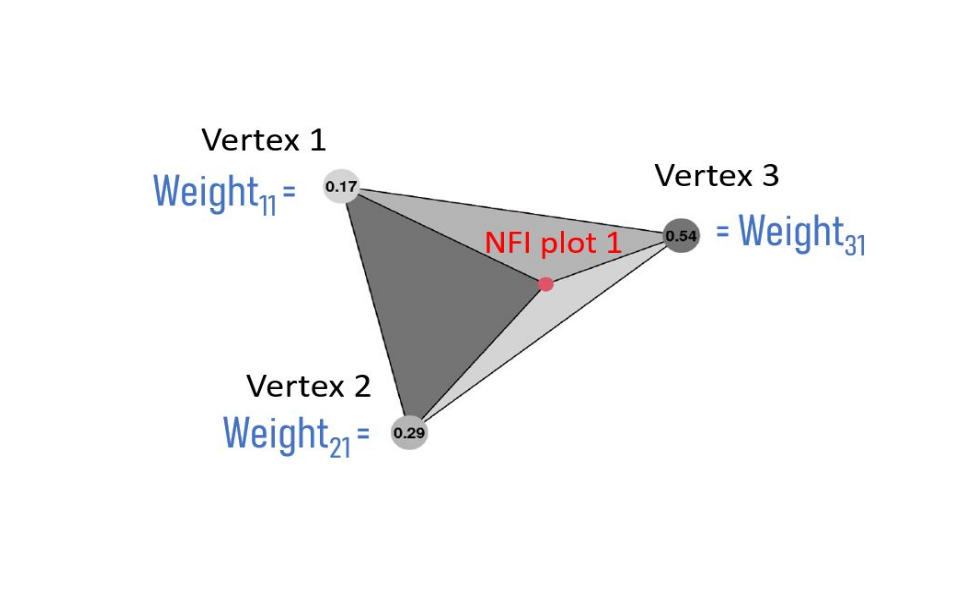

[1] "These are the number of rows (NFI plots) times the number of columns (vertices) in our mesh: 10368 and 4541"

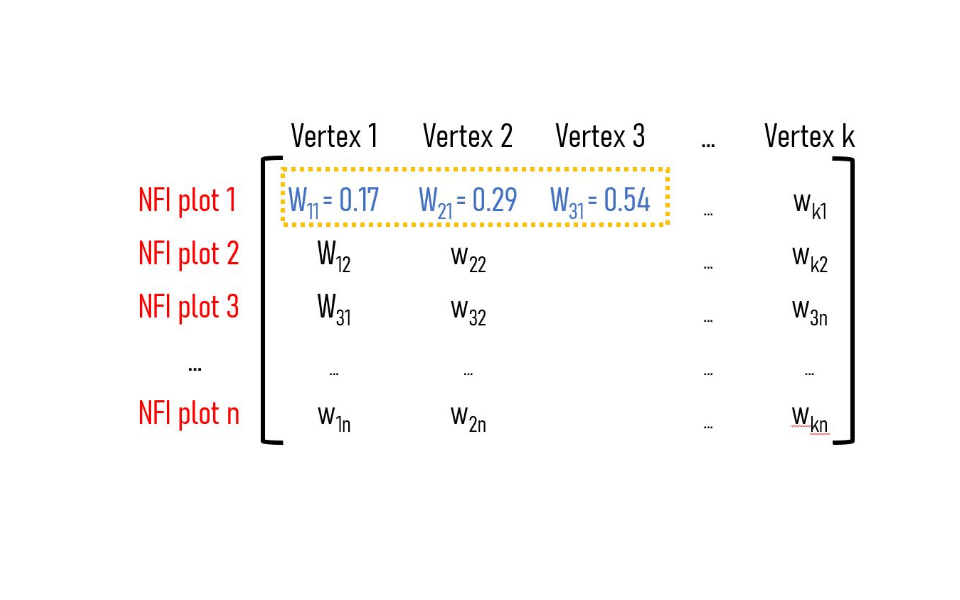

In [22]:
######################## INTERPOLATING OUR MESH TO EACH PLOT ##################

# Now, we have our data at NFI locations and we have our mesh with k vertices. Wonderful! 
# Next, we need a way to link the k mesh vertices to the n plot locations.
# This is achieved using a projector matrix (A.plot). For every NFI plot location, we come up with three weights, corresponding to the proportional 
# area to nodes/vertices of each triangle containing each NFI plot. We will explain this better in an accompanying presentation at the workshop.
# The sum of the three weights given to three vertices contain an NFI plot will be 1.   
# This results in a huge matrix of dimensions n_NFI_plots x n_vertices matrix.

options(repr.plot.width=8, repr.plot.height=5)

Example_weights <- readJPEG("/projects/ADE_biomass_harmonization/biomass_harmonization/NASA_CMS_2023/Mexico/Aplot.jpg",native=TRUE)
plot(0:1,0:1,type="n",ann=FALSE,axes=FALSE)
rasterImage(Example_weights,0,0,1,1)

Example_Aplot <- readJPEG("/projects/ADE_biomass_harmonization/biomass_harmonization/NASA_CMS_2023/Mexico/Aplot_matrix.jpg",native=TRUE)
plot(0:1,0:1,type="n",ann=FALSE,axes=FALSE)
rasterImage(Example_Aplot,0,0,1,1)

loc.plot <- data.matrix(loc.plot)
A.plot = inla.spde.make.A(mesh = mesh, loc = loc.plot)

# You can look more closely into what A.plot looks like, but it should be rather intuitive: 
paste("These are the number of rows (NFI plots) times the number of columns (vertices) in our mesh:", dim(A.plot)[1], "and", dim(A.plot)[2]) 
# dim(A.plot) gives you number of rows (9863 NFI plots) x number of columns (16094 vertices in our mesh)
# Matrix::rowSums(A.plot) ### And this tells you that the sum of all rows = 1, meaning the sum of weights at each NFI plot is 1

### Finally, here is a great resource for understanding spatial effects: https://www.paulamoraga.com/book-geospatial/sec-geostatisticaldataexamplespatial.html

In [23]:
######################## MAKING A SPATIAL MODEL FOR ALPHA, BETA AND ETA  ##################

# This part is a little tricky. What you want to do is establish that alpha_tilde, beta_tilde, and eta_tilde 
# must be modelled with a covariance function, such that covariance between any two locations will depend on the relative 
# distance between them. There are many ways to define this function, but commonly used family of covariance function is the 
# Matérn covariance function. Matérn covariance function is probably the most commonly used one in geostatistics. 
# We do not want to dive into the math here (we can do that later), but let's, for now, understand just this: 

# Taking alpha_tilde as an example, we want to know the "range" (in units of meters) at which alpha_tilde will 
# decay in correlation with distance. Similarly, we want to know the "range" at which beta_tilde and eta_tilde decays. 
# And, we want to know what is the standard deviation (SD) of the Guassian process. 

# In the followng, we simply supply these spatial models using INLA. We also supply some "prior probability" bound on the data, meaning, we give 
# INLA a starting point to optimize the model fitting. This is just a best guess on how the spatially-varying parameters are expected to behave. 

# Priors for the varying intercept alpha_tilde
spde.alpha = inla.spde2.pcmatern(mesh, 
                                 prior.range = c(30*10^3, 0.01), # This says the probability that the range is LESS than 30 km is 0.01
                                 prior.sigma = c(60, 0.01)) # This says the probability that the SD is GREATER than 60 Mg/ha is 0.01

# Priors for the varying coefficient beta_tilde
spde.beta = inla.spde2.pcmatern(mesh, 
                                prior.range = c(30*10^3, 0.01), # Same interpretations as above here
                                prior.sigma = c(1, 0.5)) # This says the probability that the SD is GREATER than 1 is 0.5

# Priors for the varying coefficient eta_tilde
spde.eta = inla.spde2.pcmatern(mesh, 
                                prior.range = c(30*10^3, 0.01), # Same interpretations as above here
                                prior.sigma = c(1, 0.5)) # This says the probability that the SD is GREATER than 1 is 0.5

# If you are keen on understanding the range and SD parameters and intuitively see how the work, here is a nice simulation: 

In [24]:
###################### SETTING UP THE MODEL SO THAT INLA CAN RUN IT ##################

# This cell simply rearranges all the data we have into the right syntax/format needed by INLA to solve the model. 
# Let's have a recap what data we have:  
# (1) We have NFI AGBD, CCI AGBD and Forest Height at each NFI location
# (2) We have an awesome mesh covering Japan in little triangles that encompass the NFI plot locations
# (3) We have a projector matrix (A.plot), which gives each NFI location 3 weights from the nearest vertices of the containing triangle
# (4) We have a spatial-model that will help us understand the spatially-varying errors alpha-tilde, beta-tilde, and eta-tilde

### First, we just construct our formula, which we need to provide to INLA #####
formula = agbd ~ # This is the NFI-estimated AGBD, which we have to predict
  -1 +           # This informs INLA that it should not use a default intercept, but use the one we provide
  intercept +    # Intercept
  cci +          # CCI values
  hei +          # Forest height values
  f(alpha.spat, model = spde.alpha) + # Spatially-varying error term, modelled with spde.alpha
  f(beta.spat, model = spde.beta) +   # Spatially-varying error term, modelled with spde.beta
  f(eta.spat, model = spde.eta)       # Spatially-varying error term, modelled with spde.eta

#### Second, we arrange our data so we can supply it to INLA to input in the formula above #####
# The INLA stack is provided as three separate lists: 
# (1) The "data" list, which is only our NFI-estimated AGBD at each plot
# (2) The "A" list, which contains our projection matrices for each model parameter. For alpha, beta and eta, this is just 1. 
#     But for alpha-tilde, beta-tilde and eta-tilde, we use A.plot to "project" on our mesh nodes! 
# (3) The "effects" list, which contains the actual values of our model parameters. We have observations of CCI and Forest 
#     height. For all other model parameters (i.e. the intercept and the random effects), we just supply an index.  

stack = inla.stack(data = list(agbd = agbd.plot),
                   A = list(1, # tell INLA we expect an intercept, and the projection matrix is just "1"
                            1, # tell INLA we expect a cci biomass value, and the projection matrix for its parameter is just "1"
                            1, # tell INLA we expect a forest height value, and the projection matrix for its parameter is just "1"
                            A.plot, # tell INLA we have a mesh projected onto the plot locations for alpha-tilde 
                            Diagonal(x = cci.plot)%*%A.plot, # tell INLA to multiply our mesh with CCI values for beta-tilde
                            Diagonal(x = hei.plot)%*%A.plot),# tell INLA to multiply our mesh with forest height values for eta-tilde
                   effects = list(
                     intercept = rep(1, n.plot), # The intercept just given an index equal to 1
                     cci = cci.plot, # Supply INLA with the CCI values
                     hei = hei.plot, # Supply INLA with the Forest Height values
                     alpha.spat = 1:k, # The random effects just need to given unique indices at each mesh node.
                     beta.spat = 1:k, # The random effects just need to given unique indices at each mesh node.
                     eta.spat = 1:k # The random effects just need to given unique indices at each mesh node.
                   ))


Call:
   c("inla.core(formula = formula, family = family, contrasts = contrasts, 
   ", " data = data, quantiles = quantiles, E = E, offset = offset, ", " 
   scale = scale, weights = weights, Ntrials = Ntrials, strata = strata, 
   ", " lp.scale = lp.scale, link.covariates = link.covariates, verbose = 
   verbose, ", " lincomb = lincomb, selection = selection, control.compute 
   = control.compute, ", " control.predictor = control.predictor, 
   control.family = control.family, ", " control.inla = control.inla, 
   control.fixed = control.fixed, ", " control.mode = control.mode, 
   control.expert = control.expert, ", " control.hazard = control.hazard, 
   control.lincomb = control.lincomb, ", " control.update = 
   control.update, control.lp.scale = control.lp.scale, ", " 
   control.pardiso = control.pardiso, only.hyperparam = only.hyperparam, 
   ", " inla.call = inla.call, inla.arg = inla.arg, num.threads = 
   num.threads, ", " keep = keep, working.directory = working.directory,

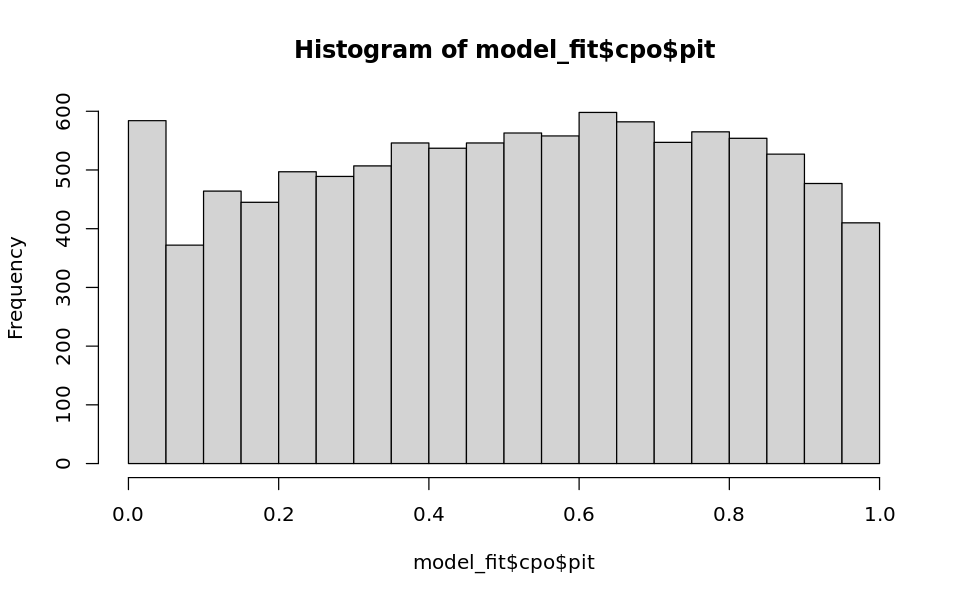

In [25]:
###################### SET THE MODEL RUNNING ###############################

model_fit = inla(formula = formula, # Provide the formula
                 family = 'gaussian', # We assume our data follows a Gaussian generalized linear model (GLM)
                 data = inla.stack.data(stack), # This line and the one below are simply how we feed INLA the stack.
                 control.predictor = list(A = inla.stack.A(stack)),
                 control.compute = list(config = TRUE, dic = TRUE, waic = TRUE, cpo = TRUE ), # As for Bayesian diagnostics, which help understand results
                 verbose = TRUE)
summary(model_fit)
hist(model_fit$cpo$pit, breaks = 20) 
save(model_fit, file = "/projects/my-public-bucket/Data/NASA_CMS_2023/JAPAN/INLA_model_fit.RData")

# A nice feature of fitting models in INLA is that you can ask it to do a leave-one-out cross validation while fitting. This is done by setting cpo = TRUE. 
# When run, this gives you a PIT (probability integral transform, The PIT is the probability of a new response less than the observed response using a model based on the rest of the data). 
# We’d expect the PIT values to be uniformly distributed if the model assumptions are correct.
# If the model represents the observation well, the distribution of the PIT values should be close to a uniform distribution between 0 and 1. 

# load("/projects/my-public-bucket/Data/NASA_CMS_2023/JAPAN/INLA_model_fit.RData")
# summary(model_fit)
# options(repr.plot.width=4, repr.plot.height=4)
# hist(model_fit$cpo$pit, breaks = 20) 

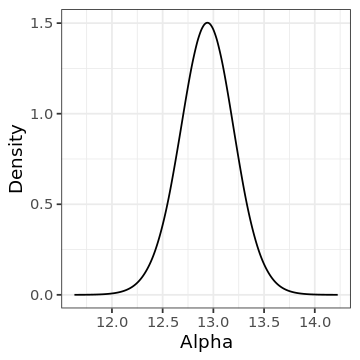

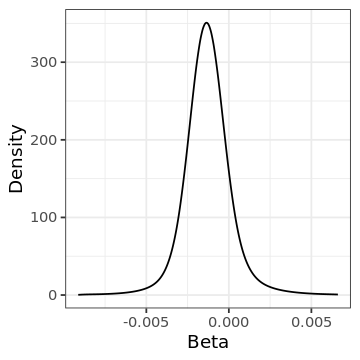

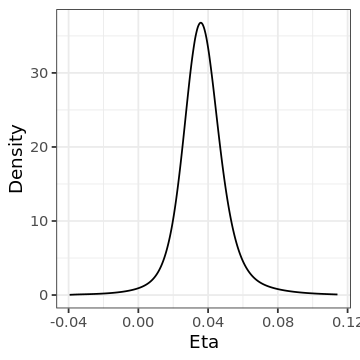

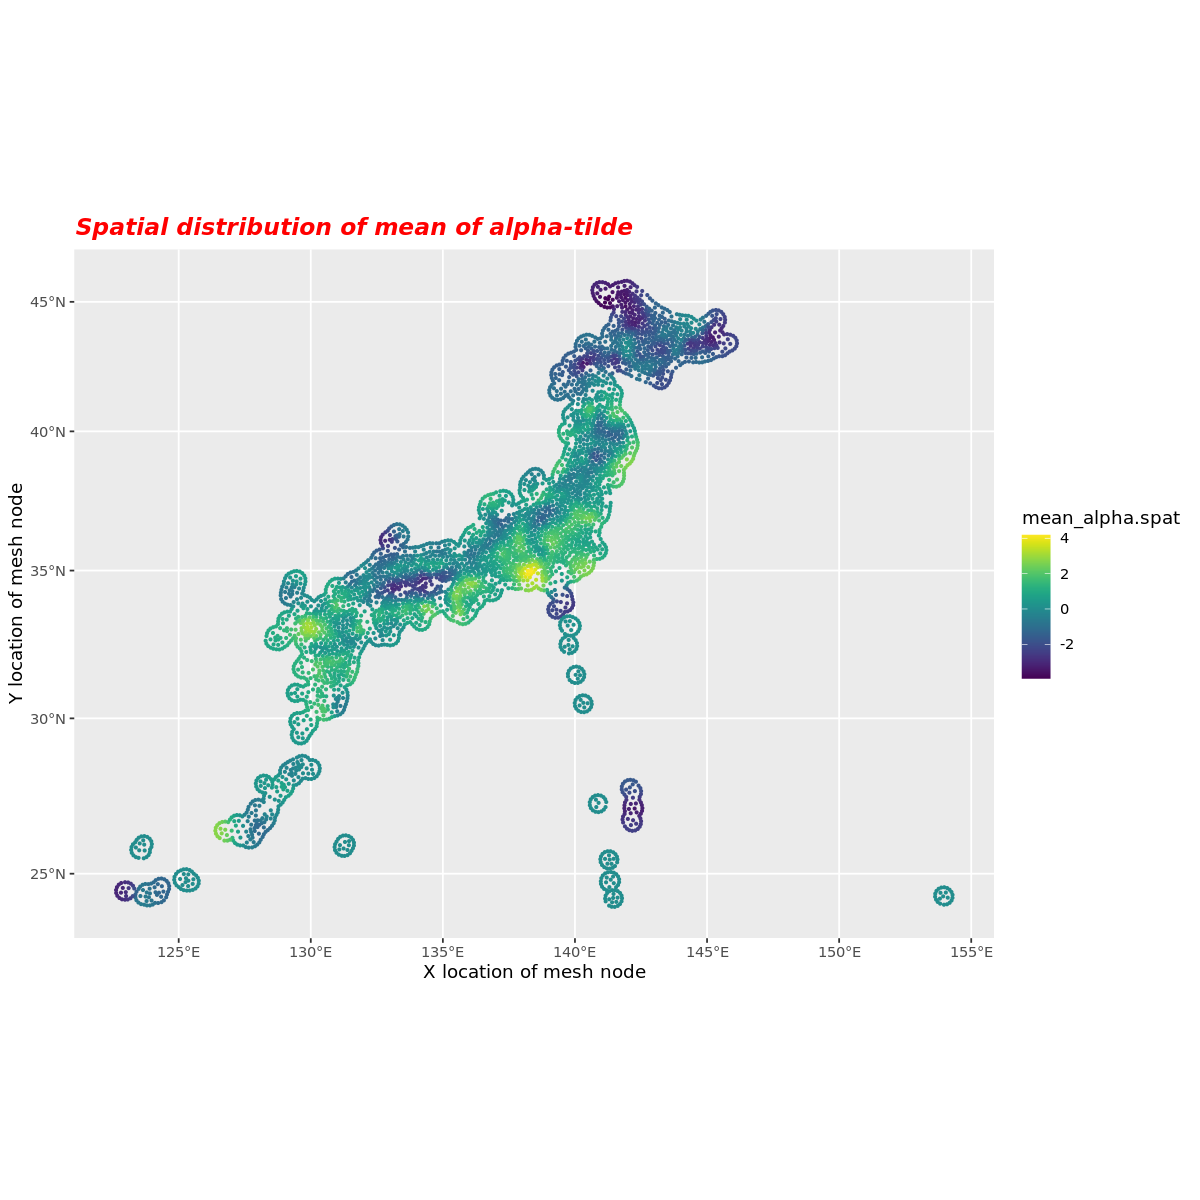

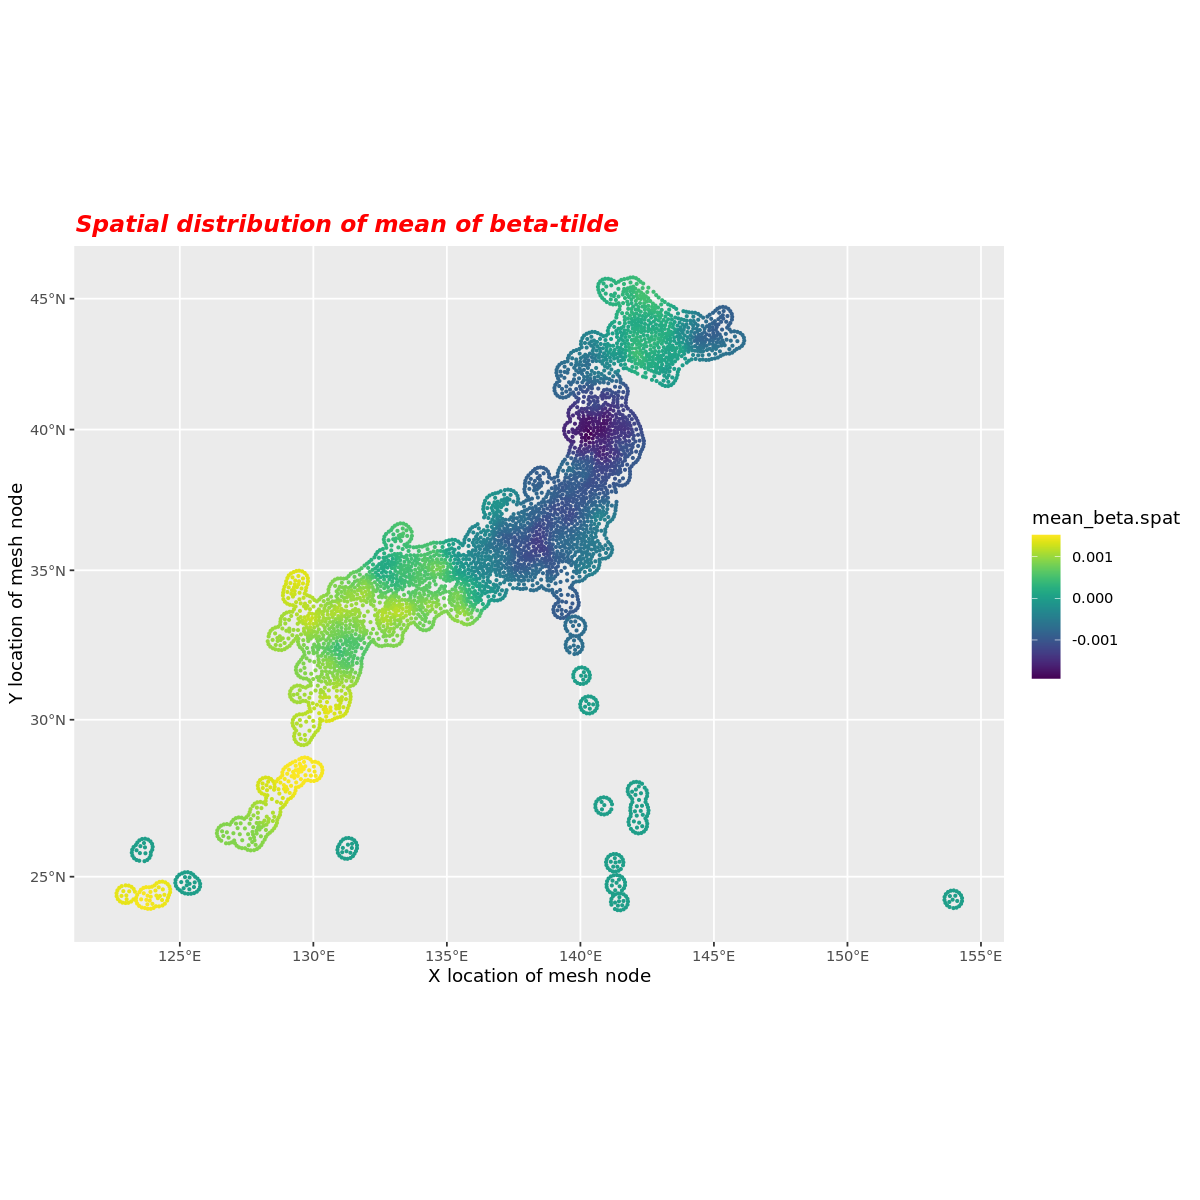

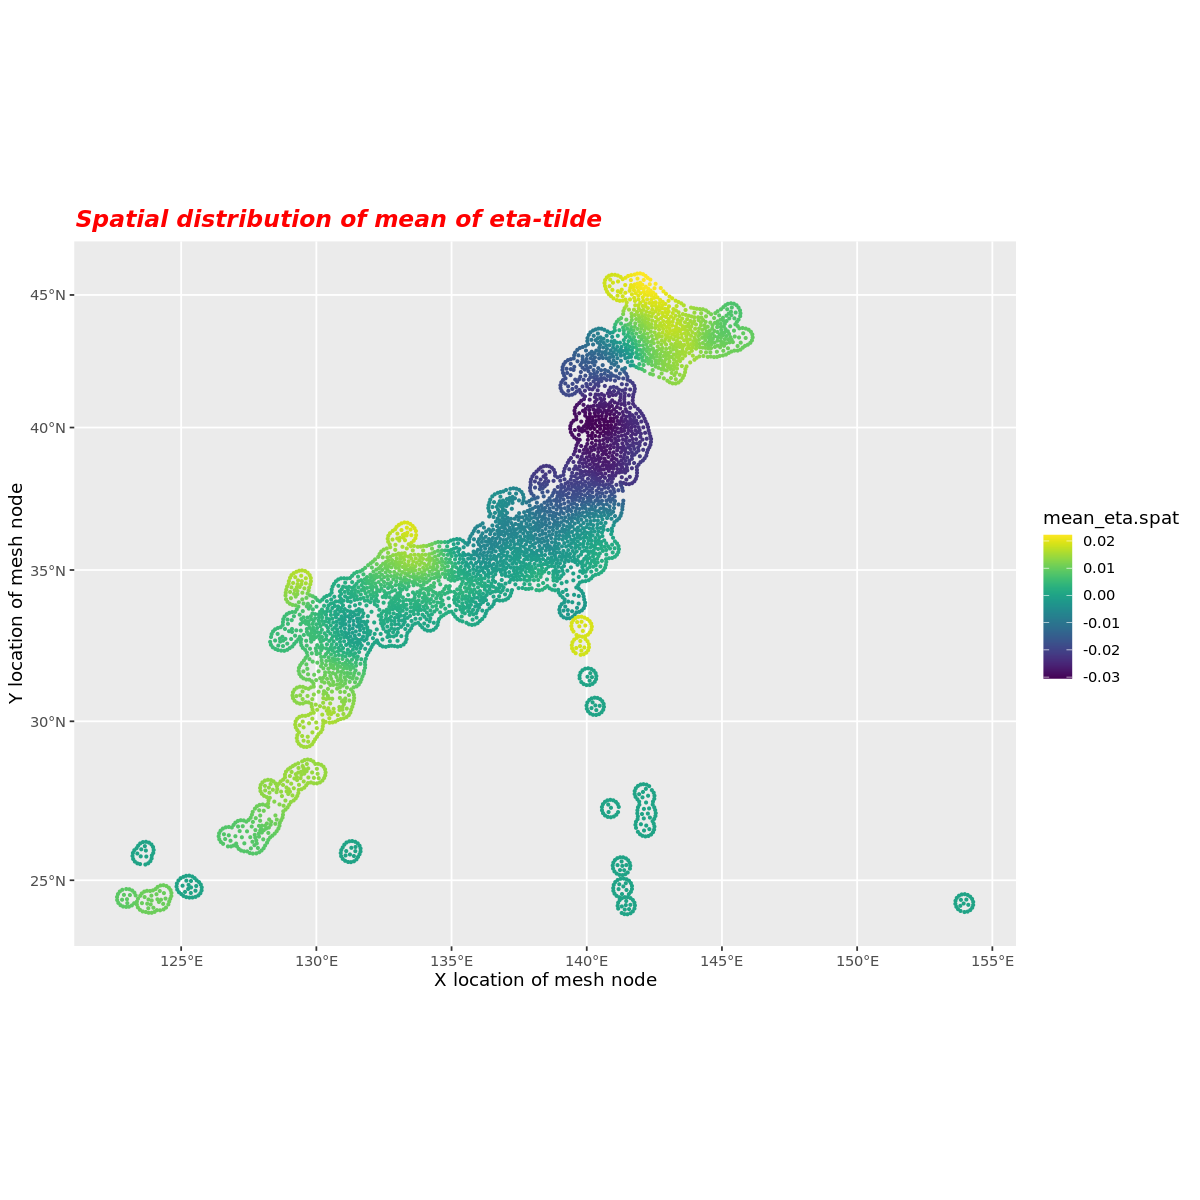

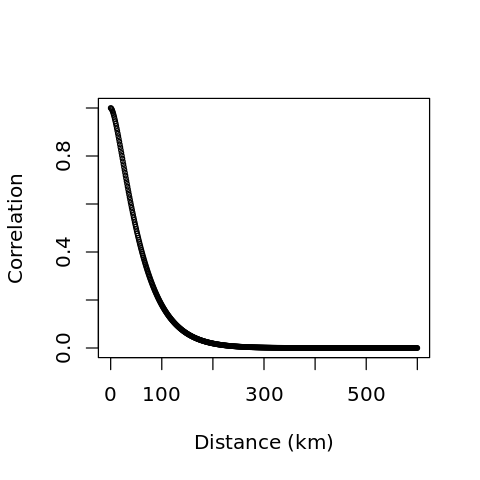

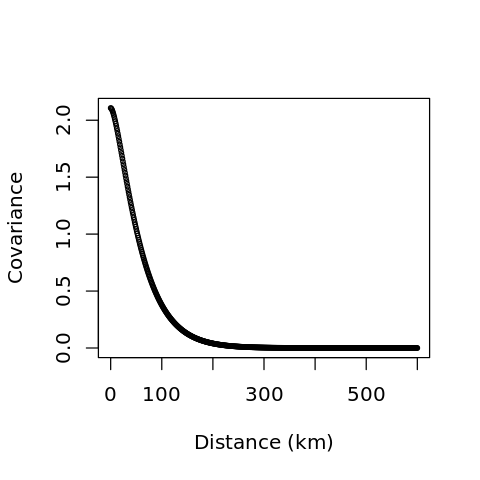

In [26]:
############################ UNDERSTANDING THE RESULTS OF THE MODEL #######################
options(repr.plot.width=3, repr.plot.height=3)

# When inla() is executed, we obtain an object of class "inla" that contains the information of the fitted model 
# including summaries and posterior marginal densities of the fixed effects, 
# the random effects, and the hyperparameters (and many more things, but we explore only these for now). 

# The fixed effects are straighforward to understand. Below, we see the posterior elements of the intercept alpha, and parameters beta and eta. 
alpha <- model_fit$marginals.fixed[[1]]
beta <- model_fit$marginals.fixed[[2]]
eta <- model_fit$marginals.fixed[[3]]
ggplot(data.frame(inla.smarginal(alpha)), aes(x, y)) + geom_line() + theme_bw() + xlab("Alpha") + ylab("Density")
ggplot(data.frame(inla.smarginal(beta)), aes(x, y)) + geom_line() + theme_bw() + xlab("Beta") + ylab("Density")
ggplot(data.frame(inla.smarginal(eta)), aes(x, y)) + geom_line() + theme_bw() + xlab("Eta") + ylab("Density")

# The random effects, in our case, are also easy to understand from the model outputs. The posterior distributions of the range and SD of alpha.spat, 
# beta.spat and eta.spat show us how these random effects vary across Japan.

options(repr.plot.width=10, repr.plot.height=10)

mean_alpha.spat <- model_fit$summary.random[[1]]$mean # mean values of alpha.spat at each mesh vertex
sd_alpha.spat <- model_fit$summary.random[[1]]$sd # standard deviation of alpha.spat at each mesh node 

mean_beta.spat <- model_fit$summary.random[[2]]$mean # mean values of alpha.spat at each mesh vertex
sd_beta.spat <- model_fit$summary.random[[2]]$sd # standard deviation of alpha.spat at each mesh node 

mean_eta.spat <- model_fit$summary.random[[3]]$mean # mean values of alpha.spat at each mesh vertex
sd_eta.spat <- model_fit$summary.random[[3]]$sd # standard deviation of alpha.spat at each mesh node 

ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = mesh$loc[,1], y = mesh$loc[,2], col = mean_alpha.spat),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis() + xlab("X location of mesh node") + ylab("Y location of mesh node") + ggtitle("Spatial distribution of mean of alpha-tilde") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))

ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = mesh$loc[,1], y = mesh$loc[,2], col = mean_beta.spat),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis() + xlab("X location of mesh node") + ylab("Y location of mesh node") + ggtitle("Spatial distribution of mean of beta-tilde") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))

ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = mesh$loc[,1], y = mesh$loc[,2], col = mean_eta.spat),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis() + xlab("X location of mesh node") + ylab("Y location of mesh node") + ggtitle("Spatial distribution of mean of eta-tilde") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))

options(repr.plot.width=4, repr.plot.height=4)

# Let's also plot the corelation vs. distance and covariance vs. distance for alpha.spat to see how the spatial process decays with distance. 

range = model_fit$summary.hyperpar[2,]$mean / 1000 #posterior expected range in kilometers
dist.seq = 0:600 # and we want a plot for these distance values
smoothness = 1 # We used the default smoothness of 1 for the Matern Covariance in INLA
matern.cor.seq = fields::Matern(d = dist.seq, # Compute and plot the correlations
                                range = range/sqrt(8*smoothness), # This divisor adjusts to the INLA parameterization
                                smoothness = smoothness)
plot(dist.seq, matern.cor.seq, xlab = "Distance (km)", ylab = "Correlation",cex=0.5)
matern.sd = model_fit$summary.hyperpar[3,]$mean # Compute covariance by multiplying by the variance parameter (SD parameter squared)
plot(dist.seq, matern.cor.seq*matern.sd^2, xlab = "Distance (km)", ylab = "Covariance",cex=0.5)

# DIC, WAIC and the CPO and PIT are standard Bayesian model diagnostics, which tell us how our model is performing. 


Call:
   c("inla.core(formula = formula, family = family, contrasts = contrasts, 
   ", " data = data, quantiles = quantiles, E = E, offset = offset, ", " 
   scale = scale, weights = weights, Ntrials = Ntrials, strata = strata, 
   ", " lp.scale = lp.scale, link.covariates = link.covariates, verbose = 
   verbose, ", " lincomb = lincomb, selection = selection, control.compute 
   = control.compute, ", " control.predictor = control.predictor, 
   control.family = control.family, ", " control.inla = control.inla, 
   control.fixed = control.fixed, ", " control.mode = control.mode, 
   control.expert = control.expert, ", " control.hazard = control.hazard, 
   control.lincomb = control.lincomb, ", " control.update = 
   control.update, control.lp.scale = control.lp.scale, ", " 
   control.pardiso = control.pardiso, only.hyperparam = only.hyperparam, 
   ", " inla.call = inla.call, inla.arg = inla.arg, num.threads = 
   num.threads, ", " keep = keep, working.directory = working.directory,

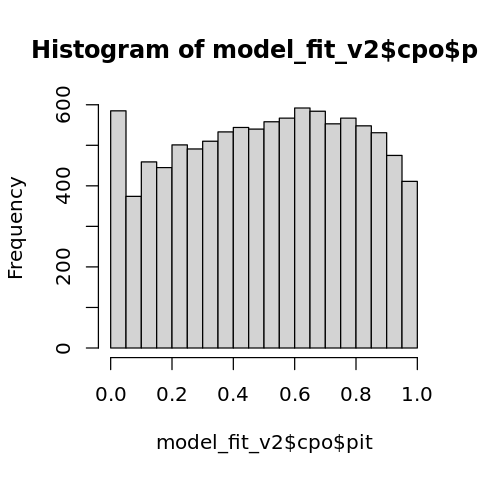

In [27]:
################## IMPROVING OUR MODEL ############

# Before we move ahead, let's try improve our model by making a finer mesh. We choose to rougly half our max.edge (8 km) and see if our model improves. 

max.edge = 8*10^3
Japan.buffer = st_buffer(Japan, dist = max.edge*5) # We also make a 5 km buffer around Japan to prevent boundary effects.
mesh = inla.mesh.2d(boundary = list(as(Japan, "Spatial"), as(Japan.buffer, "Spatial")), max.edge = c(max.edge, 3*max.edge), cutoff = 2*max.edge/3, offset = c(max.edge, 5*max.edge)) 
k = mesh$n ### This is the resulting number of vertices
A.plot = inla.spde.make.A(mesh = mesh, loc = loc.plot) # make a new projector matrix with the new mesh and the same plot locations. In case loc.plot is a df rather than matrix, use "loc.plot <- data.matrix(loc.plot)"
spde.alpha = inla.spde2.pcmatern(mesh, 
                                 prior.range = c(30*10^3, 0.01), # This says the probability that the range is LESS than 30 km is 0.01
                                 prior.sigma = c(60, 0.01)) # This says the probability that the sd is GREATER than 60 Mg/ha is 0.01

# Priors for the varying coefficient beta_tilde
spde.beta = inla.spde2.pcmatern(mesh, 
                                prior.range = c(30*10^3, 0.01), # Same interpretations here
                                prior.sigma = c(1, 0.5)) # This says the probability that the sd is GREATER than 1 is 0.5

# Priors for the varying coefficient eta_tilde
spde.eta = inla.spde2.pcmatern(mesh, 
                                prior.range = c(30*10^3, 0.01), # Same interpretations here
                                prior.sigma = c(1, 0.5)) # This says the probability that the sd is GREATER than 1 is 0.5
### Construct our formula #####
formula = agbd ~
  -1 + # removes the automatic intercept so you can include your named intercept
  intercept + 
  cci +
  hei +
  f(alpha.spat, model = spde.alpha) + 
  f(beta.spat, model = spde.beta) +
  f(eta.spat, model = spde.eta)
## Arrange our data so we can supply it to INLA to input in the formula above #####
stack = inla.stack(data = list(agbd = agbd.plot),
                   A = list(1, 
                            1, 
                            1, 
                            A.plot, 
                            Diagonal(x = cci.plot)%*%A.plot, # 
                            Diagonal(x = hei.plot)%*%A.plot),
                   effects = list(
                     intercept = rep(1, n.plot),
                     cci = cci.plot,
                     hei = hei.plot,
                     alpha.spat = 1:k, 
                     beta.spat = 1:k, 
                     eta.spat = 1:k
                   ))

# Below, notice the arguments in 'control.mode = ' We tell INLA our starting parameters in "theta=", but tell it to restart the optimization from 
# there (restart = T), using the outputs of model_fit generated previously. It will still take a while, but less than it would have if we started from scratch

model_fit_v2 = inla(formula = formula, # Provide the formula
                 family = 'gaussian', # We assume our data follows a Gaussian generalized linear model (GLM)
                 data = inla.stack.data(stack), # These line and the one below are simply how we feed INLA the stack.
                 control.predictor = list(A = inla.stack.A(stack)),
                 control.compute = list(config = T, dic = T, waic = T, cpo = T),
                 control.inla = list(int.strategy = "eb"), # EB just fixes the hyperparameters at their maximum posterior (like maximum likelihood, but accounting for priors) values. The other methods manually integrate across the range of possible values.
                 control.mode = list(theta = model_fit$mode$theta, restart = T), #Ask INLA to restart the model using the previous iteration
                 verbose = TRUE)
summary(model_fit_v2)
save(model_fit_v2, file = "/projects/my-public-bucket/Data/NASA_CMS_2023/JAPAN/INLA_model_fit_v2.RData")
hist(model_fit_v2$cpo$pit, breaks = 20) 

# options(repr.plot.width=4, repr.plot.height=4)
# load("/projects/my-public-bucket/Data/NASA_CMS_2023/JAPAN/INLA_model_fit_v2.RData")
# summary(model_fit_v2)
# hist(model_fit_v2$cpo$pit, breaks = 20) 

# We don't see a massive improvement in either the PIT distributions, the DIC or WAIC values. 
# We can conclude that using a max.edge of 8 km is sufficient and there is no further need to refine our mesh. 

Cannot preload entire working area of 7320536588 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 579107655 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 39 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 39 rows containing missing values (`geom_point()`).”


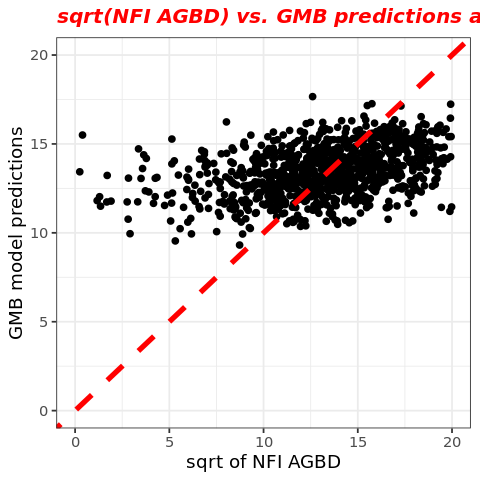

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


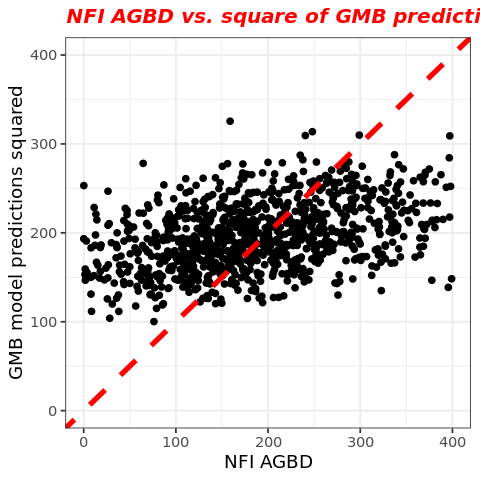

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


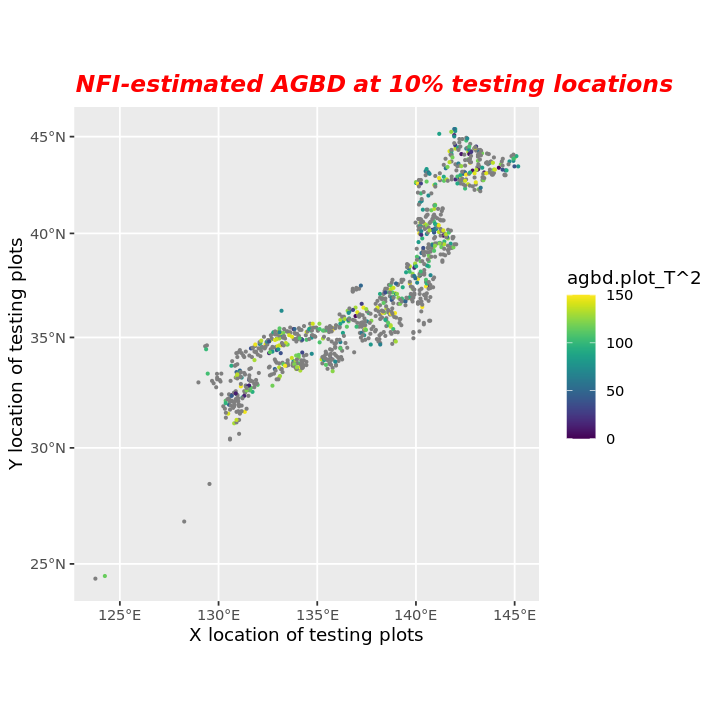

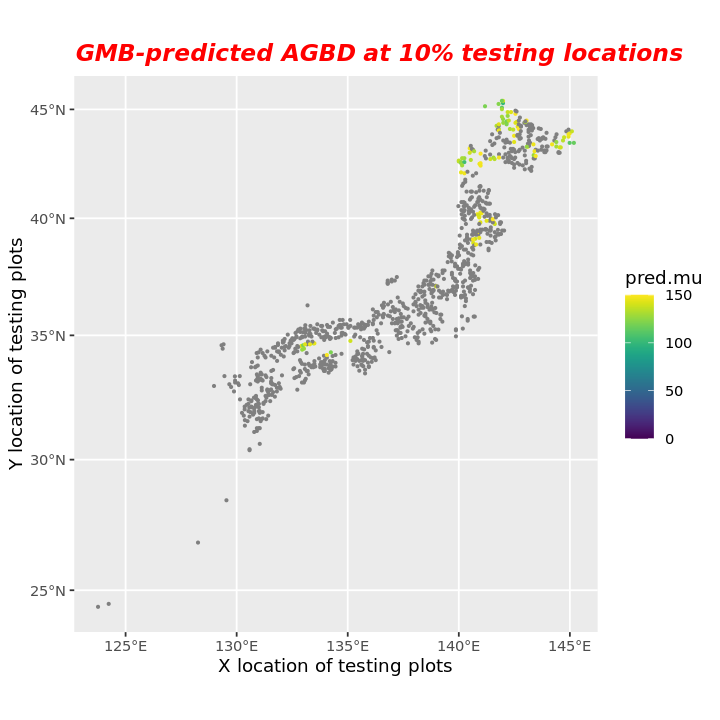

In [29]:
########################## LET'S CHECK HOW OUR MODEL PERFORMS ON OUR "TESTING" NFI LOCATIONS ############

# At the start of this notebook, we had split the NFI data into 90% for training and 10% for testing. In this cell, we 
# see how our model performs in the 10% of testing data. The method to predict AGBD at any location after model-fitting is 
# to draw posterior samples from the distributions of your model parameters and effects. We take a moment to understand this: 

# You draw posterior samples do compute things numerically that would be otherwise difficult to compute. Take this example:
# Let random variable X follow a squared normal distribution, i.e. X = Z^2 where Z is normal with mean \mu and standard deviation \sigma. 
# It's actually not very easy to compute he expected value or standard deviation of X with pencil and paper. 
# But something that would be really easy to do is draw a 1000 random samples from Z, square them (this gives you 1000 random samples from X), 
# and then take the sample mean and sample standard deviation of these samples. This would give you an estimate of these quantities. 
# As you draw more samples, this estimate converges to the true answer.

# This same reasoning follows for our application. You cant compute with "pencil-and-paper" the mean and standard deviation of AGBD predictions. 
# But you can draw random samples of the required parameters and effects, take the appropriate linear combinations, and then get random samples 
# from our posterior distribution of the AGBD at the prediction locations! The more samples you draw, the more accurately you can compute the 
# mean, std, quantiles, etc. Of course, there are diminishing returns. After you draw 2000 samples, for instance, your answer will essentially 
# be the same as if you drew 10,000 samples.

# When we ask INLA to "draw samples", it draws 2000 samples of the spatial effects at each mesh node. For a prediction inside a triangle, it then it linearly 
# interpolates all those 2000 samples to get 2000 "predictions" for that location.

# Let's start with our plot locations, draw samples from our posterior distributions and predict AGBD at our locations!

plot_T = plot_WGS84_T %>% st_transform("epsg:6933") ### convert testing plot locations to a projected CRS
agbd.plot_T = sqrt(plot_T$AGB) ### get the AGBD estimate at each plot location and square root it
loc.plot_T = st_coordinates(plot_T) ### save the plot location xy coordinates in projected CRS

hei.rast=rast("/projects/my-public-bucket/Data/NASA_CMS_2023/JAPAN/GLAD_forest_heights_2020_6933.tif")### Read GLAD FOREST HEIGHT raster, already in projected CRS
hei.pred = exactextractr::exact_extract(hei.rast, st_buffer(plot_T,17.84), 'mean') # Extract pixel values under plot using weighted-mean of area of each pixel
# hei.pred = terra::extract(hei.rast, st_buffer(plot_T,17.84)) ### Extract pixel-level height values at each NFI plot location + 17.84 buffer
# hei.pred = aggregate(x = hei.pred$GLAD_FH_Japan_UINT16_C_6399, by = list(hei.pred$ID), FUN = mean, na.rm=TRUE)[,2] ### Average pixel values per plot

cci.rast=rast("/projects/my-public-bucket/Data/NASA_CMS_2023/JAPAN/CCI_Japan_6933.tif") ### Read CCI raster, already in projected CRS
cci.pred = exactextractr::exact_extract(cci.rast, st_buffer(plot_T,17.84), 'mean') # Extract pixel values under plot using weighted-mean of area of each pixel
# cci.pred = terra::extract(cci.rast, st_buffer(plot_T,17.84)) ### Extract CCI pixel-level AGBD values at each NFI plot location + 17.84 buffer
# cci.pred = aggregate(x = cci.pred$cci_Japan, by = list(cci.pred$ID), FUN = mean, na.rm=TRUE)[,2] ### Average pixel values per plot

# Now, we have to draw "posterior samples" from our model results because it is numerically difficult to compute what our model parameters are at any given location. 
# By drawing samples from the model outputs, we are able to describe the expected model outcomes and use them in predicting AGBD at our desired testing plot locations. 

samples = inla.posterior.sample(n = 250, result = model_fit_v2)  ### Draw 2000 samples

# We also need to reconstruct our projector matrix because we now have new plot locations. We use the same mesh (8 km max.edge), and the new 
# plot locations to create the new matrix. 
A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) 

# # Our prediction function, supplied with both the model parameters and the covariates. 
pred_fun = function(...){
  drop(intercept + 
    cci.pred*cci + 
    hei.pred*hei +
    A.pred%*%alpha.spat[1:k] +  
    Diagonal(x = cci.pred)%*%A.pred%*%beta.spat[1:k] +
    Diagonal(x = hei.pred)%*%A.pred%*%eta.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) # INLA stores the precision (1/variance) for the random noise in theta[1]. So 1/theta[1] gives you the variance and square-rooting it gives you the sd
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples)
pred.sd = apply(pred.samples, 1, sd)

OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, NFI=agbd.plot_T, PRED.SD=pred.sd, RES=agbd.plot_T-pred.mu))
ggplot(data = OUTPUT, aes(x = NFI,y = PRED))+ geom_point() + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,20) + ylim(0,20) + xlab("sqrt of NFI AGBD") + ylab("GMB model predictions") + ggtitle("sqrt(NFI AGBD) vs. GMB predictions at 10% testing locations") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"))

# Let's also square the model expectations because we applied a sqrt transformation at the start
pred.mu = Matrix::rowMeans(pred.samples^2)
pred.sd = apply(pred.samples^2, 1, sd)

OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, NFI=agbd.plot_T^2, PRED.SD=pred.sd, RES=agbd.plot_T^2-pred.mu))
ggplot(data = OUTPUT, aes(x = NFI,y = PRED))+ geom_point()  + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,400) + ylim(0,400) + xlab("NFI AGBD") + ylab("GMB model predictions squared") + ggtitle("NFI AGBD vs. square of GMB predictions at 10% testing locations") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"))

####################### And here are some maps to see what the predictions look like at the plot locations ##########
options(repr.plot.width=6, repr.plot.height=6)
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = agbd.plot_T^2),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 150)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("NFI-estimated AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic")) +
           geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 150)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("GMB-predicted AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic")) + 
           geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

Cannot preload entire working area of 7809967860 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 617789238 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Warning message:
“Removed 548 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 68 rows containing non-finite values (`stat_bin2d()`).”


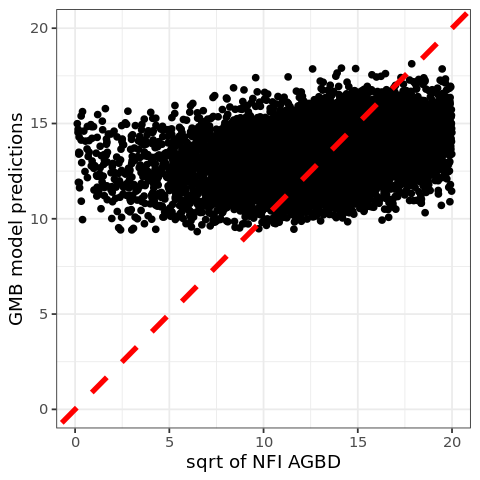

Warning message:
“Removed 548 rows containing missing values (`geom_point()`).”


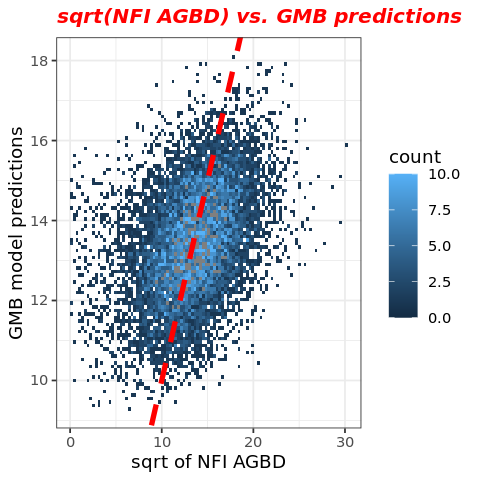

Warning message:
“Removed 68 rows containing non-finite values (`stat_bin2d()`).”


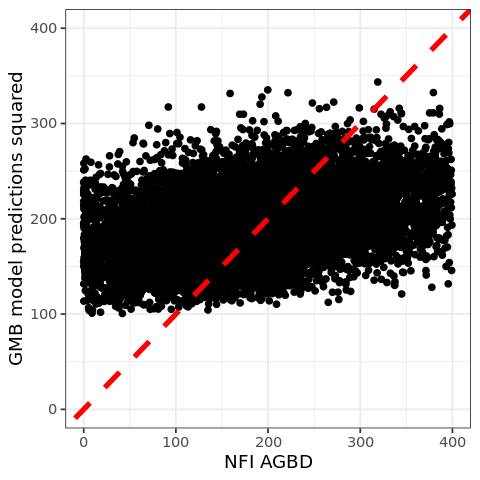

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


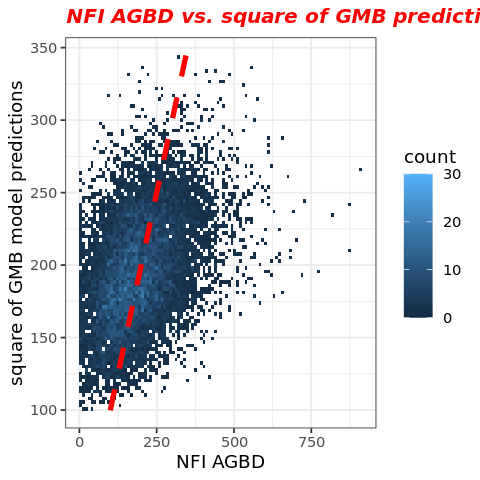

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


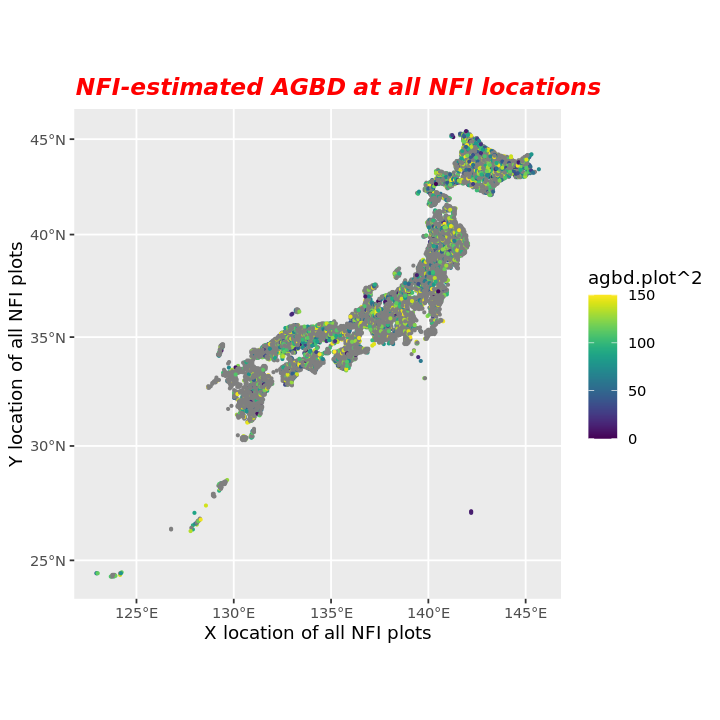

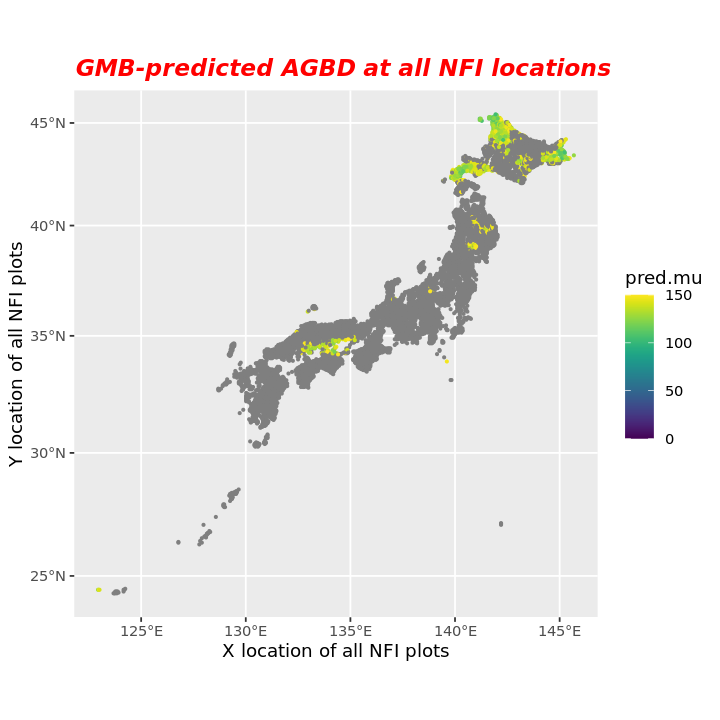

In [31]:
########################## LET'S CHECK HOW OUR MODEL PERFORMS AT ALL NFI LOCATIONS (TESTING AND TRAINING) ##################

# Just to get a complete picture, we revert back to our whole dataset (including the 90% training and 10% testing data) and predict AGBD. 

plot_WGS84 <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/JAPAN/jp_NFI.gpkg", quiet = TRUE)
loc.plot.WGS84 <- st_coordinates(plot_WGS84)  ### get the plot locations in WGS84
plot = plot_WGS84 %>% st_transform("epsg:6933") ### convert them to a projected CRS
agbd.plot = sqrt(plot$AGB) ### get the AGBD estimate at each plot location and square root it
loc.plot = st_coordinates(plot) ### save the plot location xy coordinates in projected CRS

hei.rast=rast("/projects/my-public-bucket/Data/NASA_CMS_2023/JAPAN/GLAD_forest_heights_2020_6933.tif")### Read GLAD FOREST HEIGHT raster, already in projected CRS
hei.pred = exactextractr::exact_extract(hei.rast, st_buffer(plot,17.84), 'mean') # Extract pixel values under plot using weighted-mean of area of each pixel
# hei.pred = terra::extract(hei.rast, st_buffer(plot,17.84)) ### Extract pixel-level height values at each NFI plot location + 17.84 buffer
# hei.pred = aggregate(x = hei.pred$GLAD_FH_Japan_UINT16_C_6399, by = list(hei.pred$ID), FUN = mean, na.rm=TRUE)[,2] ### Average pixel values per plot

cci.rast=rast("/projects/my-public-bucket/Data/NASA_CMS_2023/JAPAN/CCI_Japan_6933.tif") ### Read CCI raster, already in projected CRS
cci.pred = exactextractr::exact_extract(cci.rast, st_buffer(plot,17.84), 'mean') # Extract pixel values under plot using weighted-mean of area of each pixel
# cci.pred = terra::extract(cci.rast, st_buffer(plot,17.84)) ### Extract CCI pixel-level AGBD values at each NFI plot location + 17.84 buffer
# cci.pred = aggregate(x = cci.pred$cci_Japan, by = list(cci.pred$ID), FUN = mean, na.rm=TRUE)[,2] ### Average pixel values per plot

samples = inla.posterior.sample(n = 250, result = model_fit_v2)
A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot) 

# # Our prediction equation. 
pred_fun = function(...){
  drop(intercept + 
    cci.pred*cci + 
    hei.pred*hei +
    A.pred%*%alpha.spat[1:k] +   
    Diagonal(x = cci.pred)%*%A.pred%*%beta.spat[1:k] +
    Diagonal(x = hei.pred)%*%A.pred%*%eta.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples))

# Model mean AGBD expectations and SD's at the grid locations
options(repr.plot.width=4, repr.plot.height=4)

pred.mu = Matrix::rowMeans(pred.samples)
pred.sd = apply(pred.samples, 1, sd)

OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, NFI=agbd.plot, PRED.SD=pred.sd, RES=agbd.plot-pred.mu))
ggplot(data = OUTPUT, aes(x = NFI,y = PRED))+ geom_point() + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,20) + ylim(0,20) + xlab("sqrt of NFI AGBD") + ylab("GMB model predictions")

ggplot(data = OUTPUT, aes(x = NFI,y = PRED)) +
  geom_bin2d(bins = 100) + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) +
  scale_fill_gradient(limits = c(0, 10)) + xlab("sqrt of NFI AGBD") + ylab("GMB model predictions") + ggtitle("sqrt(NFI AGBD) vs. GMB predictions") +
  theme_bw() + theme(plot.title = element_text(color="red", size=12, face="bold.italic"))

# Let's also square the model expectations because we applied a sqrt transformation at the start
pred.mu = Matrix::rowMeans(pred.samples^2)
pred.sd = apply(pred.samples^2, 1, sd)

OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, NFI=agbd.plot^2, PRED.SD=pred.sd, RES=agbd.plot^2-pred.mu))
ggplot(data = OUTPUT, aes(x = NFI,y = PRED))+ geom_point()  + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,400) + ylim(0,400) + xlab("NFI AGBD") + ylab("GMB model predictions squared")

ggplot(data = OUTPUT, aes(x = NFI,y = PRED)) +
  geom_bin2d(bins = 100) + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) +
  scale_fill_gradient(limits = c(0, 30)) + xlab("NFI AGBD") + ylab("square of GMB model predictions") + ggtitle("NFI AGBD vs. square of GMB predictions") +
  theme_bw() + theme(plot.title = element_text(color="red", size=12, face="bold.italic"))

####################### And here are some maps to see what the results look like ##########
options(repr.plot.width=6, repr.plot.height=6)
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot[,1], y = loc.plot[,2], col = agbd.plot^2),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 150)) + xlab("X location of all NFI plots") + ylab("Y location of all NFI plots") + ggtitle("NFI-estimated AGBD at all NFI locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic")) +
           geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot[,1], y = loc.plot[,2], col = pred.mu),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 150)) + xlab("X location of all NFI plots") + ylab("Y location of all NFI plots") + ggtitle("GMB-predicted AGBD at all NFI locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic")) +
           geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

In [ ]:
########################## LET'S GAP-FILL Japan's LOCATIONS WHERE Japan'S THIRD NFI IS INCOMPLETE ##################

# Japan's third NFI cycle was incomplete due to several accessibility and funding issues. 
# We know the locations at which plots should have been measured, and can use our model to predict AGBD at those locations

options(repr.plot.width=10, repr.plot.height=10)

# Read the locations where plots were not measured
MISSING_plot_WGS84 <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/JAPAN/MISSING_Coordenades_INFyS_2y3_conafor.gpkg", quiet = TRUE)
MISSING.loc.plot.WGS84 <- st_coordinates(MISSING_plot_WGS84)  ### get the plot locations in WGS84
MISSING.plot = MISSING_plot_WGS84 %>% st_transform("epsg:6933") ### convert them to a projected CRS
MISSING.loc.plot = st_coordinates(MISSING.plot) ### save the plot location xy coordinates in projected CRS

# # We'll need our covariate values at the grid locations
hei.rast=rast("/projects/my-public-bucket/Data/NASA_CMS_2023/JAPAN/GLAD_FH_Japan_UINT16_C_6399.tif")### Read GLAD FOREST HEIGHT raster, already in projected CRS
hei.pred = exactextractr::exact_extract(hei.rast, st_buffer(MISSING.plot,17.84), 'mean') # Extract pixel values under plot using weighted-mean of area of each pixel
# hei.pred = terra::extract(hei.rast, st_buffer(MISSING.plot,17.84)) ### Extract pixel-level height values at each NFI plot location + 17.84 buffer
# hei.pred = aggregate(x = hei.pred$GLAD_FH_Japan_UINT16_C_6399, by = list(hei.pred$ID), FUN = mean, na.rm=TRUE)[,2] ### Average pixel values per plot

cci.rast=rast("/projects/my-public-bucket/Data/NASA_CMS_2023/JAPAN/cci_Japan_6933.tif") ### Read CCI raster, already in projected CRS
cci.pred = exactextractr::exact_extract(cci.rast, st_buffer(MISSING.plot,17.84), 'mean') # Extract pixel values under plot using weighted-mean of area of each pixel
# cci.pred = terra::extract(cci.rast, st_buffer(MISSING.plot,17.84)) ### Extract CCI pixel-level AGBD values at each NFI plot location + 17.84 buffer
# cci.pred = aggregate(x = cci.pred$cci_Japan, by = list(cci.pred$ID), FUN = mean, na.rm=TRUE)[,2] ### Average pixel values per plot

samples = inla.posterior.sample(n = 250, result = model_fit_v2) # Draw posterior samples from our model fit 
A.pred = inla.spde.make.A(mesh = mesh, loc = MISSING.loc.plot) # Make a new projector matrix with the same mesh, but new plot locations 

# Our model function
pred_fun = function(...){
  drop(intercept + 
    cci.pred*cci + 
    hei.pred*hei +
    A.pred%*%alpha.spat[1:k] +   
    Diagonal(x = cci.pred)%*%A.pred%*%beta.spat[1:k] +
    Diagonal(x = hei.pred)%*%A.pred%*%eta.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

# # Generate prediction samples
pred.samples = (inla.posterior.sample.eval(fun = pred_fun, samples = samples))

# # Model expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples^2) # Mean AGBD values at each grid center
pred.sd = apply(pred.samples^2, 1, sd) # SD of AGBD at each grid center

ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = MISSING.loc.plot[,1], y = MISSING.loc.plot[,2], col = pred.mu),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 150)) + xlab("X location of missing NFI plots") + ylab("Y location of missing NFI plots") + ggtitle("GMB-predicted AGBD at missing NFI locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic")) + 
           geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = MISSING.loc.plot[,1], y = MISSING.loc.plot[,2], col = pred.sd),size=0.5) +  # make a map to see plot locations and SD of AGBD values at each location
           scale_color_viridis(limits = c(0, 100)) + xlab("X location of missing NFI plots") + ylab("Y location of missing NFI plots") + ggtitle("SD of GMB-predicted AGBD at missing NFI locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic")) + 
           geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

In [ ]:
############## AND FINALLY, LET'S PREDICT AGBD WHERE WE MAY HAVE (HYPOTHETICAL) DEFORESTATION IN THE FUTURE ############

# And this is where the notebook finally gets interesting! Imagine if we had a patch of land where we are interested in predicting AGBD. 
# How do we apply our model to the entire area covered by this land to predict mean AGBD and its associated SD? 
# We do this by selecting multiple locations inside the patch of land. The locations must be at least 17.84 x 2 m apart, which is the size of our NFI plot. 
# Then, we predict AGBD at all those locations (just like we did in the cells above). As a result, we will have multiple predictions of mean AGBD. 
# Finally, we simply take the mean of these mean AGBD values, and their standard deviation. 

# For simplicity, we have created two polygons of (hypothetically) disturbed forest. We loop through these to predict AGBD in each in a for loop. 

options(repr.plot.width=5, repr.plot.height=5)

cci.rast = rast("/projects/my-public-bucket/Data/NASA_CMS_2023/JAPAN/cci_Japan_6933.tif")
hei.rast = rast("/projects/my-public-bucket/Data/NASA_CMS_2023/JAPAN/GLAD_FH_Japan_UINT16_C_6399.tif")
samples = inla.posterior.sample(n = 250, result = model_fit_v2) # draw samples from our posterior distribution

Deforestation = st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/JAPAN/MEX_deforestation.gpkg", quiet = TRUE) %>% st_transform(crs = 6933)  # Regions of deforestation.  
for (f in range(1,length(Deforestation))) {
    
    Deforestation_ID = f
    
    # Create a 120 x 120 m grid inside our patch of land, because we will predict AGBD at each grid center!
    grid_to_predict = st_make_grid(Deforestation[f,], cellsize = c(120,120), what = "centers") %>% st_as_sf() %>% st_filter(Deforestation[f,]) 
    grid = grid_to_predict %>% st_coordinates()

    # We'll need our covariate values at the grid locations
    cci.pred = extract(cci.rast, grid)[,1]
    hei.pred = extract(hei.rast, grid)[,1]

    A.pred = inla.spde.make.A(mesh = mesh, loc = grid) # remake our projector matrix for the grid centers
    pred_fun = function(...){
      drop(intercept + 
        cci.pred*cci + 
        hei.pred*hei +
        A.pred%*%alpha.spat[1:k] +   
        Diagonal(x = cci.pred)%*%A.pred%*%beta.spat[1:k] +
        Diagonal(x = hei.pred)%*%A.pred%*%eta.spat[1:k]) +
        rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
    }
    
    # Generate prediction samples
    pred.samples = (inla.posterior.sample.eval(fun = pred_fun, samples = samples))

    # Model expectations and SD's at the grid locations
    pred.mu = Matrix::rowMeans(pred.samples^2) # Mean AGBD values at each grid center
    pred.sd = apply(pred.samples^2, 1, sd) # SD of AGBD at each grid center

    p <- ggplot() + coord_sf(crs = 6933) + 
               geom_point(aes(x = grid[,1], y = grid[,2], col=pred.mu)) + # make a map to see plot locations and the predicted AGBD values at each location
               scale_color_viridis() + ggtitle(paste0("GMB-predicted AGBD in ID: ",Deforestation_ID)) + theme(plot.title = element_text(color="red", size=14, face="bold.italic")) + xlab("") + ylab("")
    print(p)
    
    print(paste0("Deforestation ID:",Deforestation_ID," - Mean predicted AGBD: ", round(mean(pred.mu,na.rm=TRUE),digits=2) ,"Mg/ha"))
    print(paste0("Deforestation ID:",Deforestation_ID," - Predicted SD of AGBD: ", round(sd(pred.mu,na.rm=TRUE),digits=2) ,"Mg/ha"))
}

In [ ]:
############## REFERENCES #################

# Babcock et al. 2015 - https://doi.org/10.1016/j.rse.2015.07.028
# McRoberts et al. 2022 - https://www.sciencedirect.com/science/article/abs/pii/S0034425722001420
# In addition, plently of links to INLA books are provided throughout this notebook 